In [1]:
# Before running the code please ensure that the given packages are installed for the smooth running of the code:
# 1. prettytable
# 2. seaborn
# 3. tensorflow
# 4. keras
# 5. statsmodels
# 6. Prophet

In [2]:
import warnings
import itertools
import pandas as pd
import numpy as np

from pandas.plotting import table
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import seaborn as sns
%matplotlib inline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_squared_error,  make_scorer

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.tools import eval_measures
import statsmodels.formula.api as smf

from prophet import Prophet

C:\Users\samik\anaconda3\envs\BD\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


# Training Dataset

## Read Training Dataset

**Worked on By: Vaishali Gupta**

In [3]:
# Read data from .csv training files
dengue_features = pd.read_csv("dengue_features_train.csv")
dengue_labels = pd.read_csv("dengue_labels_train.csv")

# Merge the two datasets such that each feature row has its corresponding label
dengue = pd.merge(dengue_features, dengue_labels)
dengue.head()

city  year  weekofyear week_start_date   ndvi_ne   ndvi_nw   ndvi_se  \
0   sj  1990          18      1990-04-30  0.122600  0.103725  0.198483   
1   sj  1990          19      1990-05-07  0.169900  0.142175  0.162357   
2   sj  1990          20      1990-05-14  0.032250  0.172967  0.157200   
3   sj  1990          21      1990-05-21  0.128633  0.245067  0.227557   
4   sj  1990          22      1990-05-28  0.196200  0.262200  0.251200   

    ndvi_sw  precipitation_amt_mm  reanalysis_air_temp_k  ...  \
0  0.177617                 12.42             297.572857  ...   
1  0.155486                 22.82             298.211429  ...   
2  0.170843                 34.54             298.781429  ...   
3  0.235886                 15.36             298.987143  ...   
4  0.247340                  7.52             299.518571  ...   

   reanalysis_relative_humidity_percent  reanalysis_sat_precip_amt_mm  \
0                             73.365714                         12.42   
1                             77.368571                         22.82   
2                             82.052857                         34.54   
3                             80.337143                         15.36   
4                             80.460000                          7.52   

   reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  \
0                              14.012857           2.628571   
1                              15.372857           2.371429   
2                              16.848571           2.300000   
3                              16.672857           2.428571   
4                              17.210000           3.014286   

   station_avg_temp_c  station_diur_temp_rng_c  station_max_temp_c  \
0           25.442857                 6.900000                29.4   
1           26.714286                 6.371429                31.7   
2           26.714286                 6.485714                32.2   
3           27.471429                 6.771429                33.3   
4           28.942857                 9.371429                35.0   

   station_min_temp_c  station_precip_mm  total_cases  
0                20.0               16.0            4  
1                22.2                8.6            5  
2                22.8               41.4            4  
3                23.3                4.0            3  
4                23.9                5.8            6  

[5 rows x 25 columns]

In [4]:
# Convert the week_start_date column to the DateTime data type
dengue["week_start_date"] = pd.to_datetime(dengue["week_start_date"])

# Set week_start_date column as index
dengue = dengue.set_index('week_start_date', drop=True)
dengue.head()

city  year  weekofyear   ndvi_ne   ndvi_nw   ndvi_se  \
week_start_date                                                        
1990-04-30        sj  1990          18  0.122600  0.103725  0.198483   
1990-05-07        sj  1990          19  0.169900  0.142175  0.162357   
1990-05-14        sj  1990          20  0.032250  0.172967  0.157200   
1990-05-21        sj  1990          21  0.128633  0.245067  0.227557   
1990-05-28        sj  1990          22  0.196200  0.262200  0.251200   

                  ndvi_sw  precipitation_amt_mm  reanalysis_air_temp_k  \
week_start_date                                                          
1990-04-30       0.177617                 12.42             297.572857   
1990-05-07       0.155486                 22.82             298.211429   
1990-05-14       0.170843                 34.54             298.781429   
1990-05-21       0.235886                 15.36             298.987143   
1990-05-28       0.247340                  7.52             299.518571   

                 reanalysis_avg_temp_k  ...  \
week_start_date                         ...   
1990-04-30                  297.742857  ...   
1990-05-07                  298.442857  ...   
1990-05-14                  298.878571  ...   
1990-05-21                  299.228571  ...   
1990-05-28                  299.664286  ...   

                 reanalysis_relative_humidity_percent  \
week_start_date                                         
1990-04-30                                  73.365714   
1990-05-07                                  77.368571   
1990-05-14                                  82.052857   
1990-05-21                                  80.337143   
1990-05-28                                  80.460000   

                 reanalysis_sat_precip_amt_mm  \
week_start_date                                 
1990-04-30                              12.42   
1990-05-07                              22.82   
1990-05-14                              34.54   
1990-05-21                              15.36   
1990-05-28                               7.52   

                 reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  \
week_start_date                                                             
1990-04-30                                   14.012857           2.628571   
1990-05-07                                   15.372857           2.371429   
1990-05-14                                   16.848571           2.300000   
1990-05-21                                   16.672857           2.428571   
1990-05-28                                   17.210000           3.014286   

                 station_avg_temp_c  station_diur_temp_rng_c  \
week_start_date                                                
1990-04-30                25.442857                 6.900000   
1990-05-07                26.714286                 6.371429   
1990-05-14                26.714286                 6.485714   
1990-05-21                27.471429                 6.771429   
1990-05-28                28.942857                 9.371429   

                 station_max_temp_c  station_min_temp_c  station_precip_mm  \
week_start_date                                                              
1990-04-30                     29.4                20.0               16.0   
1990-05-07                     31.7                22.2                8.6   
1990-05-14                     32.2                22.8               41.4   
1990-05-21                     33.3                23.3                4.0   
1990-05-28                     35.0                23.9                5.8   

                 total_cases  
week_start_date               
1990-04-30                 4  
1990-05-07                 5  
1990-05-14                 4  
1990-05-21                 3  
1990-05-28                 6  

[5 rows x 24 columns]

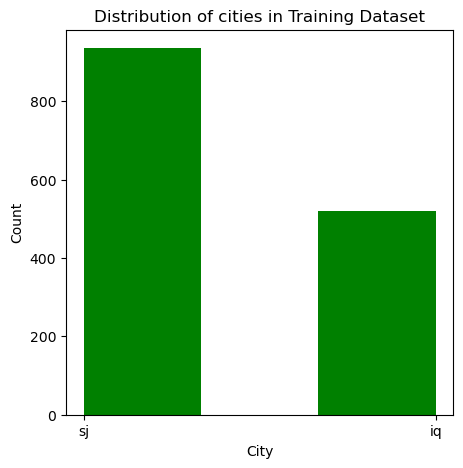

In [5]:
# Plot the graph to check for different cities and their distribution in the Dataset
plt.figure(figsize = (5,5))
plt.hist(dengue["city"], bins=3, color='g')
plt.title("Distribution of cities in Training Dataset")
plt.xlabel("City")
plt.ylabel("Count")
plt.show()

## Split Dataset for the two Cities

**Worked on By: Vaishali Gupta**

In [6]:
# Split the dataset into separate cities because we don't want imputation from one city's data into another.
dengue_sj = dengue[dengue["city"] == "sj"]
dengue_iq = dengue[dengue["city"] == "iq"]

# Drop city column
dengue_sj = dengue_sj.drop("city", axis=1)
dengue_iq = dengue_iq.drop("city", axis=1)    

In [7]:
dengue_iq.head()

year  weekofyear   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
week_start_date                                                             
2000-07-01       2000          26  0.192886  0.132257  0.340886  0.247200   
2000-07-08       2000          27  0.216833  0.276100  0.289457  0.241657   
2000-07-15       2000          28  0.176757  0.173129  0.204114  0.128014   
2000-07-22       2000          29  0.227729  0.145429  0.254200  0.200314   
2000-07-29       2000          30  0.328643  0.322129  0.254371  0.361043   

                 precipitation_amt_mm  reanalysis_air_temp_k  \
week_start_date                                                
2000-07-01                      25.41             296.740000   
2000-07-08                      60.61             296.634286   
2000-07-15                      55.52             296.415714   
2000-07-22                       5.60             295.357143   
2000-07-29                      62.76             296.432857   

                 reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  ...  \
week_start_date                                                      ...   
2000-07-01                  298.450000                   295.184286  ...   
2000-07-08                  298.428571                   295.358571  ...   
2000-07-15                  297.392857                   295.622857  ...   
2000-07-22                  296.228571                   292.797143  ...   
2000-07-29                  297.635714                   293.957143  ...   

                 reanalysis_relative_humidity_percent  \
week_start_date                                         
2000-07-01                                  92.418571   
2000-07-08                                  93.581429   
2000-07-15                                  95.848571   
2000-07-22                                  87.234286   
2000-07-29                                  88.161429   

                 reanalysis_sat_precip_amt_mm  \
week_start_date                                 
2000-07-01                              25.41   
2000-07-08                              60.61   
2000-07-15                              55.52   
2000-07-22                               5.60   
2000-07-29                              62.76   

                 reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  \
week_start_date                                                             
2000-07-01                                   16.651429           8.928571   
2000-07-08                                   16.862857          10.314286   
2000-07-15                                   17.120000           7.385714   
2000-07-22                                   14.431429           9.114286   
2000-07-29                                   15.444286           9.500000   

                 station_avg_temp_c  station_diur_temp_rng_c  \
week_start_date                                                
2000-07-01                26.400000                10.775000   
2000-07-08                26.900000                11.566667   
2000-07-15                26.800000                11.466667   
2000-07-22                25.766667                10.533333   
2000-07-29                26.600000                11.480000   

                 station_max_temp_c  station_min_temp_c  station_precip_mm  \
week_start_date                                                              
2000-07-01                     32.5                20.7                3.0   
2000-07-08                     34.0                20.8               55.6   
2000-07-15                     33.0                20.7               38.1   
2000-07-22                     31.5                14.7               30.0   
2000-07-29                     33.3                19.1                4.0   

                 total_cases  
week_start_date               
2000-07-01                 0  
2000-07-08                 0  
2000-07-15                 0  
2000-07-22                 0  
2000-07-29                 0 

In [8]:
# Recognizing different types of features and the target variable in the datasets
time_features = ['year', 'weekofyear']
ndvi_features = ['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw']
weather_features = ['precipitation_amt_mm', 'reanalysis_air_temp_k',
                    'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
                    'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
                    'reanalysis_precip_amt_kg_per_m2',
                    'reanalysis_relative_humidity_percent', 
                    'reanalysis_sat_precip_amt_mm',
                    'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
                    'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
                    'station_min_temp_c', 'station_precip_mm']
target = ['total_cases']

## Handle Missing Values in the two Cities Datasets

**Worked on By: Samiksha Sharma**

In [9]:
# Function to create a Table with Columns and their Null Values for a DataFrame
def CountMissingValues(df, col_with_null, Column_label):
    NullColTable = PrettyTable(["Column", Column_label])
    for col in col_with_null:
        NullColTable.add_row([col, df[col].isnull().sum()])
    return NullColTable

In [10]:
# Function to replace/fill all missing values using SimpleImputer
def ReplaceMissingValues(df, cols_with_null, choice_strategy):
    for col in cols_with_null:
        imputer = SimpleImputer(missing_values = np.nan, strategy = choice_strategy)
        imputer = imputer.fit(pd.DataFrame(df[col]))
        df[col] = imputer.transform(pd.DataFrame(df[col]))
    return df

In [11]:
# Find columns with any null values
col_with_null_sj = dengue_sj.columns[dengue_sj.isnull().any()]
col_with_null_iq = dengue_iq.columns[dengue_iq.isnull().any()]

In [12]:
# Count Null Values in each city dataset
# Call function to create tables with the count of null values in each column
NullColumnsTable_sj = CountMissingValues(dengue_sj, col_with_null_sj, "Count of Null/Missing Values for San Juan")
print(NullColumnsTable_sj)
NullColumnsTable_iq = CountMissingValues(dengue_iq, col_with_null_iq, "Count of Null/Missing Values for Iquitos")
print(NullColumnsTable_iq)

+---------------------------------------+-------------------------------------------+
|                 Column                | Count of Null/Missing Values for San Juan |
+---------------------------------------+-------------------------------------------+
|                ndvi_ne                |                    191                    |
|                ndvi_nw                |                     49                    |
|                ndvi_se                |                     19                    |
|                ndvi_sw                |                     19                    |
|          precipitation_amt_mm         |                     9                     |
|         reanalysis_air_temp_k         |                     6                     |
|         reanalysis_avg_temp_k         |                     6                     |
|      reanalysis_dew_point_temp_k      |                     6                     |
|       reanalysis_max_air_temp_k       |             

In [13]:
# Filling these Null/Missing Values using SimpleImputer SimpleImputer
warnings.filterwarnings("ignore")

# Call function to replace/fill all missing values with median values
dengue_sj = ReplaceMissingValues(dengue_sj, col_with_null_sj, "mean")
dengue_iq = ReplaceMissingValues(dengue_iq, col_with_null_iq, "mean")

In [14]:
# Call function to again create and print table with count of Null values in all columns and check all are zero
NullColumnsTable_sj = CountMissingValues(dengue_sj, col_with_null_sj, "Count of Null/Missing Values for San Juan")
print(NullColumnsTable_sj)
NullColumnsTable_iq = CountMissingValues(dengue_iq, col_with_null_iq, "Count of Null/Missing Values for Iquitos")
print(NullColumnsTable_iq)

+---------------------------------------+-------------------------------------------+
|                 Column                | Count of Null/Missing Values for San Juan |
+---------------------------------------+-------------------------------------------+
|                ndvi_ne                |                     0                     |
|                ndvi_nw                |                     0                     |
|                ndvi_se                |                     0                     |
|                ndvi_sw                |                     0                     |
|          precipitation_amt_mm         |                     0                     |
|         reanalysis_air_temp_k         |                     0                     |
|         reanalysis_avg_temp_k         |                     0                     |
|      reanalysis_dew_point_temp_k      |                     0                     |
|       reanalysis_max_air_temp_k       |             

## Handle Scales of Columns in the two cities Datasets

**Worked on By: Shweta Bhati**

In [15]:
# Function to scale/normalize certain columns using StandardScaler
def ScaleColumns(df, cols_to_scale):
    scaler = StandardScaler()
    for col in cols_to_scale:
        scaler=scaler.fit(pd.DataFrame(df[col]))
        df[col] = scaler.transform(pd.DataFrame(df[col]))
    return df

In [16]:
# Function to plot histograms for all scaled Weather columns in each city
def VizScaledCols(df, cols_to_scale, title):
    df[cols_to_scale].plot(kind="hist",figsize=(10,5))
    plt.title(title)
    plt.show()

In [17]:
# Data Summary for features of San Juan
dengue_sj.describe(percentiles=[]).T

count         mean        std  \
year                                   936.0  1998.826923   5.212076   
weekofyear                             936.0    26.503205  15.021909   
ndvi_ne                                936.0     0.057925   0.095584   
ndvi_nw                                936.0     0.067469   0.090023   
ndvi_se                                936.0     0.177655   0.056583   
ndvi_sw                                936.0     0.165956   0.055501   
precipitation_amt_mm                   936.0    35.470809  44.390936   
reanalysis_air_temp_k                  936.0   299.163653   1.232456   
reanalysis_avg_temp_k                  936.0   299.276920   1.214721   
reanalysis_dew_point_temp_k            936.0   295.109519   1.564898   
reanalysis_max_air_temp_k              936.0   301.398817   1.254881   
reanalysis_min_air_temp_k              936.0   297.301828   1.290544   
reanalysis_precip_amt_kg_per_m2        936.0    30.465419  35.513556   
reanalysis_relative_humidity_percent   936.0    78.568181   3.378595   
reanalysis_sat_precip_amt_mm           936.0    35.470809  44.390936   
reanalysis_specific_humidity_g_per_kg  936.0    16.552409   1.555907   
reanalysis_tdtr_k                      936.0     2.516267   0.497288   
station_avg_temp_c                     936.0    27.006528   1.410925   
station_diur_temp_rng_c                936.0     6.757373   0.833306   
station_max_temp_c                     936.0    31.607957   1.711778   
station_min_temp_c                     936.0    22.600645   1.501436   
station_precip_mm                      936.0    26.785484  29.231566   
total_cases                            936.0    34.180556  51.381372   

                                               min          50%          max  
year                                   1990.000000  1999.000000  2008.000000  
weekofyear                                1.000000    26.500000    53.000000  
ndvi_ne                                  -0.406250     0.057925     0.493400  
ndvi_nw                                  -0.456100     0.067469     0.437100  
ndvi_se                                  -0.015533     0.177655     0.393129  
ndvi_sw                                  -0.063457     0.165956     0.381420  
precipitation_amt_mm                      0.000000    21.435000   390.600000  
reanalysis_air_temp_k                   295.938571   299.239286   302.200000  
reanalysis_avg_temp_k                   296.114286   299.378571   302.164286  
reanalysis_dew_point_temp_k             289.642857   295.447143   297.795714  
reanalysis_max_air_temp_k               297.800000   301.500000   304.300000  
reanalysis_min_air_temp_k               292.600000   297.500000   299.900000  
reanalysis_precip_amt_kg_per_m2           0.000000    21.405000   570.500000  
reanalysis_relative_humidity_percent     66.735714    78.639286    87.575714  
reanalysis_sat_precip_amt_mm              0.000000    21.435000   390.600000  
reanalysis_specific_humidity_g_per_kg    11.715714    16.832143    19.440000  
reanalysis_tdtr_k                         1.357143     2.457143     4.428571  
station_avg_temp_c                       22.842857    27.214286    30.071429  
station_diur_temp_rng_c                   4.528571     6.757143     9.914286  
station_max_temp_c                       26.700000    31.700000    35.600000  
station_min_temp_c                       17.800000    22.800000    25.600000  
station_precip_mm                         0.000000    17.950000   305.900000  
total_cases                               0.000000    19.000000   461.000000

In [18]:
# Data Summary for features of Iquitos
dengue_iq.describe(percentiles=[]).T

count         mean        std  \
year                                   520.0  2005.000000   2.918283   
weekofyear                             520.0    26.503846  15.029450   
ndvi_ne                                520.0     0.263869   0.081135   
ndvi_nw                                520.0     0.238783   0.076529   
ndvi_se                                520.0     0.250126   0.077130   
ndvi_sw                                520.0     0.266779   0.086095   
precipitation_amt_mm                   520.0    64.245736  35.083014   
reanalysis_air_temp_k                  520.0   297.869538   1.166476   
reanalysis_avg_temp_k                  520.0   299.133043   1.326930   
reanalysis_dew_point_temp_k            520.0   295.492982   1.411757   
reanalysis_max_air_temp_k              520.0   307.082752   2.373780   
reanalysis_min_air_temp_k              520.0   292.866667   1.656648   
reanalysis_precip_amt_kg_per_m2        520.0    57.609864  50.092398   
reanalysis_relative_humidity_percent   520.0    88.639117   7.554608   
reanalysis_sat_precip_amt_mm           520.0    64.245736  35.083014   
reanalysis_specific_humidity_g_per_kg  520.0    17.096110   1.440187   
reanalysis_tdtr_k                      520.0     9.206783   2.439071   
station_avg_temp_c                     520.0    27.530933   0.888304   
station_diur_temp_rng_c                520.0    10.566197   1.479751   
station_max_temp_c                     520.0    34.004545   1.307264   
station_min_temp_c                     520.0    21.196680   1.250575   
station_precip_mm                      520.0    62.467262  62.263437   
total_cases                            520.0     7.565385  10.765478   

                                               min          50%          max  
year                                   2000.000000  2005.000000  2010.000000  
weekofyear                                1.000000    26.500000    53.000000  
ndvi_ne                                   0.061729     0.263869     0.508357  
ndvi_nw                                   0.035860     0.233593     0.454429  
ndvi_se                                   0.029880     0.250013     0.538314  
ndvi_sw                                   0.064183     0.262429     0.546017  
precipitation_amt_mm                      0.000000    60.505000   210.830000  
reanalysis_air_temp_k                   294.635714   297.832857   301.637143  
reanalysis_avg_temp_k                   294.892857   299.130807   302.928571  
reanalysis_dew_point_temp_k             290.088571   295.831429   298.450000  
reanalysis_max_air_temp_k               300.000000   307.082752   314.000000  
reanalysis_min_air_temp_k               286.900000   293.000000   296.000000  
reanalysis_precip_amt_kg_per_m2           0.000000    46.680000   362.030000  
reanalysis_relative_humidity_percent     57.787143    90.873571    98.610000  
reanalysis_sat_precip_amt_mm              0.000000    60.505000   210.830000  
reanalysis_specific_humidity_g_per_kg    12.111429    17.420714    20.461429  
reanalysis_tdtr_k                         3.714286     8.978571    16.028571  
station_avg_temp_c                       21.400000    27.530933    30.800000  
station_diur_temp_rng_c                   5.200000    10.566197    15.800000  
station_max_temp_c                       30.100000    34.000000    42.200000  
station_min_temp_c                       14.700000    21.300000    24.200000  
station_precip_mm                         0.000000    47.750000   543.300000  
total_cases                               0.000000     5.000000   116.000000

In [19]:
# Call the function to Scale Weather columns for each city dataset
dengue_sj = ScaleColumns(dengue_sj, weather_features)
dengue_iq = ScaleColumns(dengue_iq, weather_features)

In [20]:
# Data Summary for features of San Juan
dengue_sj.describe(percentiles=[]).T

count          mean        std  \
year                                   936.0  1.998827e+03   5.212076   
weekofyear                             936.0  2.650321e+01  15.021909   
ndvi_ne                                936.0  5.792473e-02   0.095584   
ndvi_nw                                936.0  6.746907e-02   0.090023   
ndvi_se                                936.0  1.776552e-01   0.056583   
ndvi_sw                                936.0  1.659557e-01   0.055501   
precipitation_amt_mm                   936.0  2.656944e-17   1.000535   
reanalysis_air_temp_k                  936.0  4.589681e-14   1.000535   
reanalysis_avg_temp_k                  936.0  1.220676e-14   1.000535   
reanalysis_dew_point_temp_k            936.0  7.648203e-15   1.000535   
reanalysis_max_air_temp_k              936.0  1.727773e-14   1.000535   
reanalysis_min_air_temp_k              936.0 -7.287618e-15   1.000535   
reanalysis_precip_amt_kg_per_m2        936.0 -6.832142e-17   1.000535   
reanalysis_relative_humidity_percent   936.0 -2.778404e-15   1.000535   
reanalysis_sat_precip_amt_mm           936.0  2.656944e-17   1.000535   
reanalysis_specific_humidity_g_per_kg  936.0  1.973730e-16   1.000535   
reanalysis_tdtr_k                      936.0 -2.429206e-16   1.000535   
station_avg_temp_c                     936.0  9.792736e-16   1.000535   
station_diur_temp_rng_c                936.0 -1.062778e-16   1.000535   
station_max_temp_c                     936.0 -1.017230e-15   1.000535   
station_min_temp_c                     936.0 -6.300753e-16   1.000535   
station_precip_mm                      936.0 -1.062778e-16   1.000535   
total_cases                            936.0  3.418056e+01  51.381372   

                                               min          50%          max  
year                                   1990.000000  1999.000000  2008.000000  
weekofyear                                1.000000    26.500000    53.000000  
ndvi_ne                                  -0.406250     0.057925     0.493400  
ndvi_nw                                  -0.456100     0.067469     0.437100  
ndvi_se                                  -0.015533     0.177655     0.393129  
ndvi_sw                                  -0.063457     0.165956     0.381420  
precipitation_amt_mm                     -0.799482    -0.316355     8.004315  
reanalysis_air_temp_k                    -2.618192     0.061400     2.464973  
reanalysis_avg_temp_k                    -2.604981     0.083728     2.378249  
reanalysis_dew_point_temp_k              -3.495170     0.215863     1.717448  
reanalysis_max_air_temp_k                -2.869389     0.080675     2.313155  
reanalysis_min_air_temp_k                -3.645238     0.153639     2.014314  
reanalysis_precip_amt_kg_per_m2          -0.858312    -0.255262    15.214564  
reanalysis_relative_humidity_percent     -3.504058     0.021057     2.667484  
reanalysis_sat_precip_amt_mm             -0.799482    -0.316355     8.004315  
reanalysis_specific_humidity_g_per_kg    -3.110264     0.179885     1.856882  
reanalysis_tdtr_k                        -2.332136    -0.118957     3.847520  
station_avg_temp_c                       -2.952601     0.147328     2.173425  
station_diur_temp_rng_c                  -2.676080    -0.000277     3.790444  
station_max_temp_c                       -2.868702     0.053799     2.333350  
station_min_temp_c                       -3.199079     0.132847     1.998726  
station_precip_mm                        -0.916810    -0.302420     9.553499  
total_cases                               0.000000    19.000000   461.000000

In [21]:
# Data Summary for features of Iquitos
dengue_iq.describe(percentiles=[]).T

count          mean        std  \
year                                   520.0  2.005000e+03   2.918283   
weekofyear                             520.0  2.650385e+01  15.029450   
ndvi_ne                                520.0  2.638695e-01   0.081135   
ndvi_nw                                520.0  2.387829e-01   0.076529   
ndvi_se                                520.0  2.501263e-01   0.077130   
ndvi_sw                                520.0  2.667788e-01   0.086095   
precipitation_amt_mm                   520.0  5.431553e-16   1.000963   
reanalysis_air_temp_k                  520.0 -1.190842e-14   1.000963   
reanalysis_avg_temp_k                  520.0 -5.352983e-15   1.000963   
reanalysis_dew_point_temp_k            520.0 -2.680932e-14   1.000963   
reanalysis_max_air_temp_k              520.0  5.677510e-15   1.000963   
reanalysis_min_air_temp_k              520.0 -4.618528e-15   1.000963   
reanalysis_precip_amt_kg_per_m2        520.0  2.049643e-17   1.000963   
reanalysis_relative_humidity_percent   520.0 -1.345932e-15   1.000963   
reanalysis_sat_precip_amt_mm           520.0  5.431553e-16   1.000963   
reanalysis_specific_humidity_g_per_kg  520.0  6.832142e-17   1.000963   
reanalysis_tdtr_k                      520.0 -2.254607e-16   1.000963   
station_avg_temp_c                     520.0  1.882255e-15   1.000963   
station_diur_temp_rng_c                520.0 -2.732857e-16   1.000963   
station_max_temp_c                     520.0  3.049697e-15   1.000963   
station_min_temp_c                     520.0 -1.199041e-15   1.000963   
station_precip_mm                      520.0 -6.832142e-18   1.000963   
total_cases                            520.0  7.565385e+00  10.765478   

                                               min           50%          max  
year                                   2000.000000  2.005000e+03  2010.000000  
weekofyear                                1.000000  2.650000e+01    53.000000  
ndvi_ne                                   0.061729  2.638695e-01     0.508357  
ndvi_nw                                   0.035860  2.335929e-01     0.454429  
ndvi_se                                   0.029880  2.500131e-01     0.538314  
ndvi_sw                                   0.064183  2.624285e-01     0.546017  
precipitation_amt_mm                     -1.833012 -1.067280e-01     4.182235  
reanalysis_air_temp_k                    -2.774972 -3.147586e-02     3.233015  
reanalysis_avg_temp_k                    -3.198563 -1.686416e-03     2.863138  
reanalysis_dew_point_temp_k              -3.831830  2.399653e-01     2.096582  
reanalysis_max_air_temp_k                -2.986618  2.396943e-14     2.916829  
reanalysis_min_air_temp_k                -3.605118  8.056130e-02     1.893191  
reanalysis_precip_amt_kg_per_m2          -1.151179 -2.184042e-01     6.083024  
reanalysis_relative_humidity_percent     -4.087794  2.960586e-01     1.321112  
reanalysis_sat_precip_amt_mm             -1.833012 -1.067280e-01     4.182235  
reanalysis_specific_humidity_g_per_kg    -3.464468  2.256073e-01     2.338974  
reanalysis_tdtr_k                        -2.254049 -9.365504e-02     2.799573  
station_avg_temp_c                       -6.908485  4.003285e-15     3.683665  
station_diur_temp_rng_c                  -3.629912 -1.201599e-15     3.540355  
station_max_temp_c                       -2.989683 -3.480423e-03     6.275202  
station_min_temp_c                       -5.199954  8.269777e-02     2.403863  
station_precip_mm                        -1.004240 -2.365985e-01     7.729990  
total_cases                               0.000000  5.000000e+00   116.000000

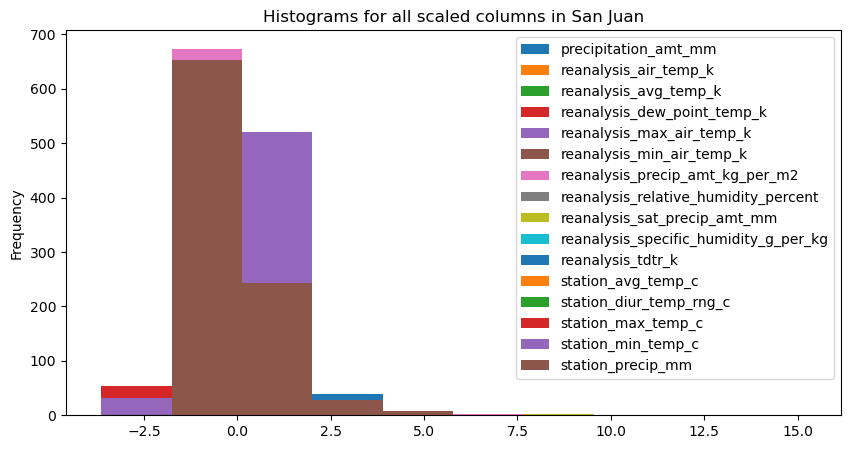

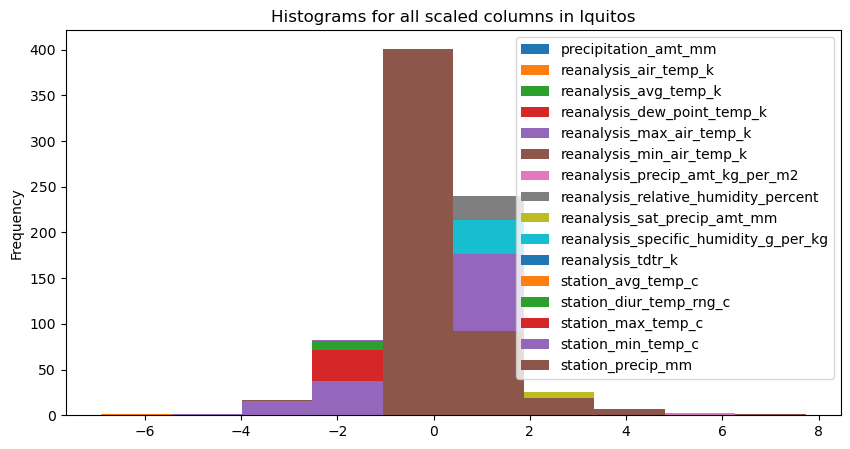

In [22]:
# Call function to visualize scaled weather columns in each city
VizScaledCols(dengue_sj, weather_features, "Histograms for all scaled columns in San Juan")
VizScaledCols(dengue_iq, weather_features, "Histograms for all scaled columns in Iquitos")

# Explore and Visualize the two cities Datasets

## Correlation

**Worked on By: Vaishali Gupta**

In [23]:
# Function to check and print correlation between features and target of a dataset
def VisualizeCorrelation(df, title):
    # Create Correlation Matrix
    corr_matrix= df.corr()

    # Visualize correlation Matrix for all columns
    plt.figure(figsize=(15, 7))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title(title)
    plt.show()

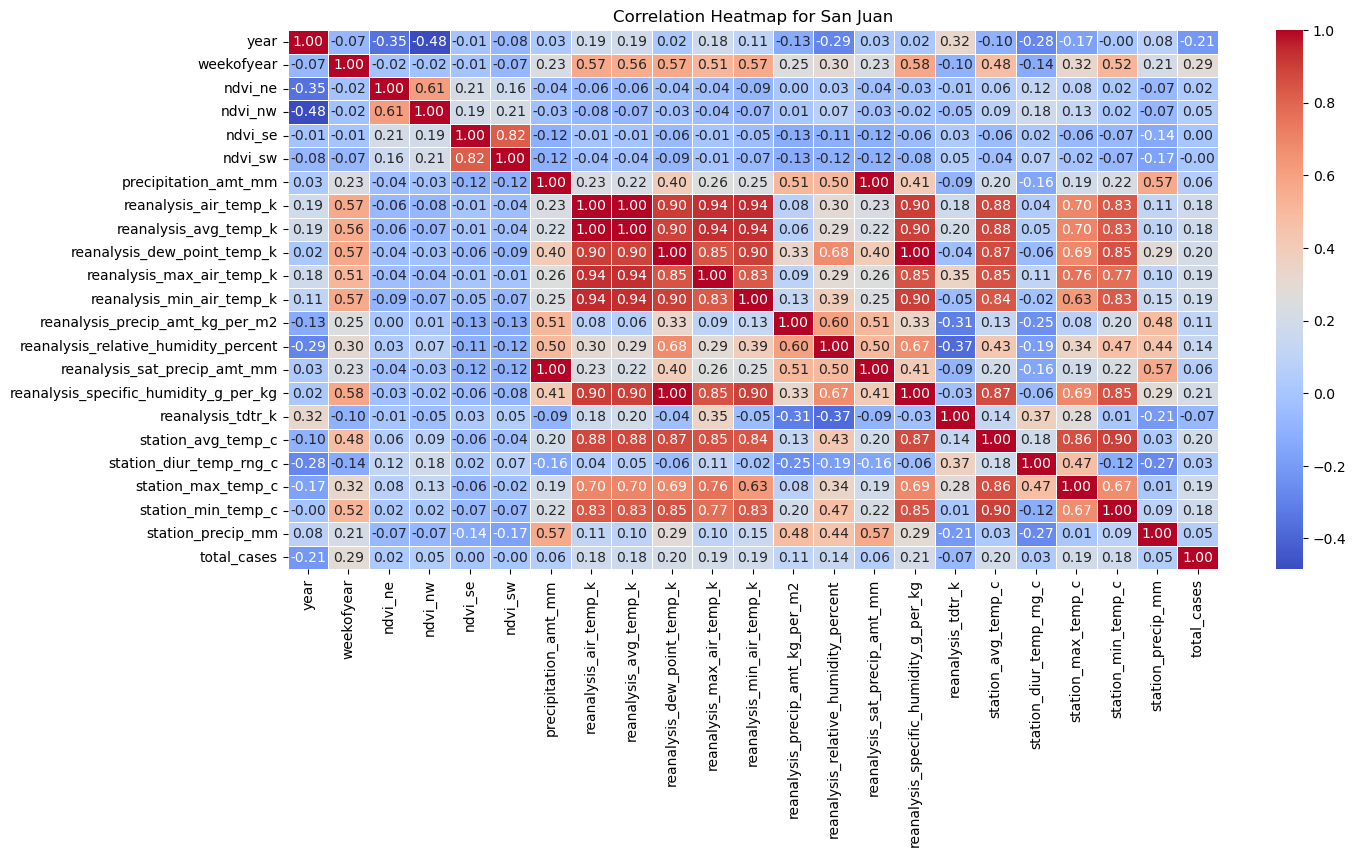

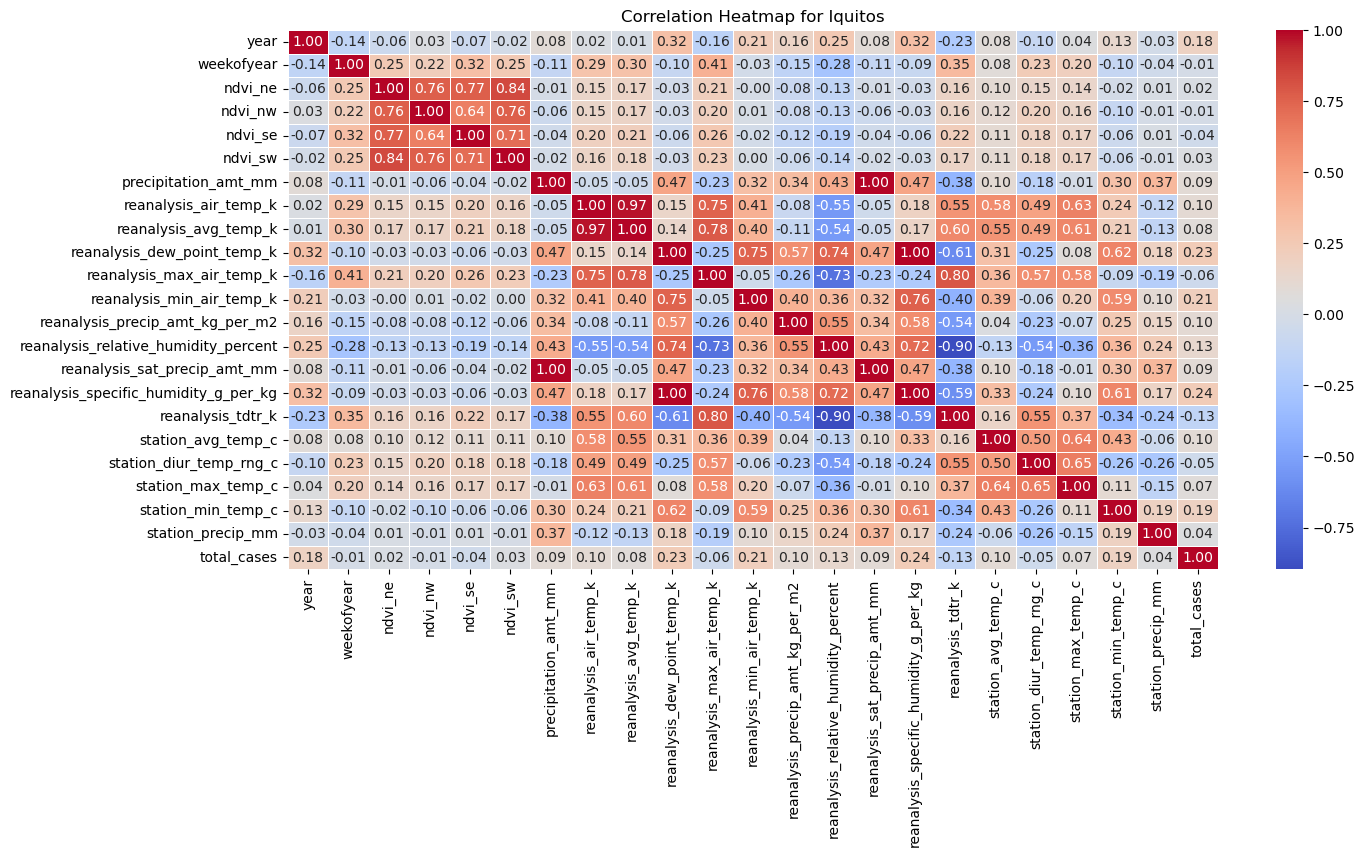

In [24]:
# Visualize the correlation between features and target using a Heatmap
VisualizeCorrelation(dengue_sj, 'Correlation Heatmap for San Juan')
VisualizeCorrelation(dengue_iq, 'Correlation Heatmap for Iquitos')

## Features

**Worked on By: Shweta Bhati and Samiksha Sharma**

In [25]:
# Function to visualize the average of a type of feature values for each week in each year
def VizFeatures(df, features, mean_features, title, ylabel):
    for i in features:
        df.groupby('weekofyear')[i].mean().plot(alpha = .3, figsize = (20, 5)).legend(loc='center left', bbox_to_anchor=(1, 0.5))
    for j in mean_features:
        df.groupby('weekofyear')[j].mean().plot(alpha = 1, c = 'k', linewidth = 2).legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('Week of Year')
    plt.show()

### NDVI features w.r.t 'weekofyear'

In [26]:
dengue_sj['ndvi_north'] = dengue_sj[['ndvi_ne', 'ndvi_nw']].mean(axis=1)
dengue_sj['ndvi_south'] = dengue_sj[['ndvi_se', 'ndvi_sw']].mean(axis=1)
dengue_iq['ndvi_mean'] = dengue_iq[['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw']].mean(axis=1)
ndvi_features_mean_sj = ['ndvi_north', 'ndvi_south']
ndvi_features_mean_iq = ['ndvi_mean']

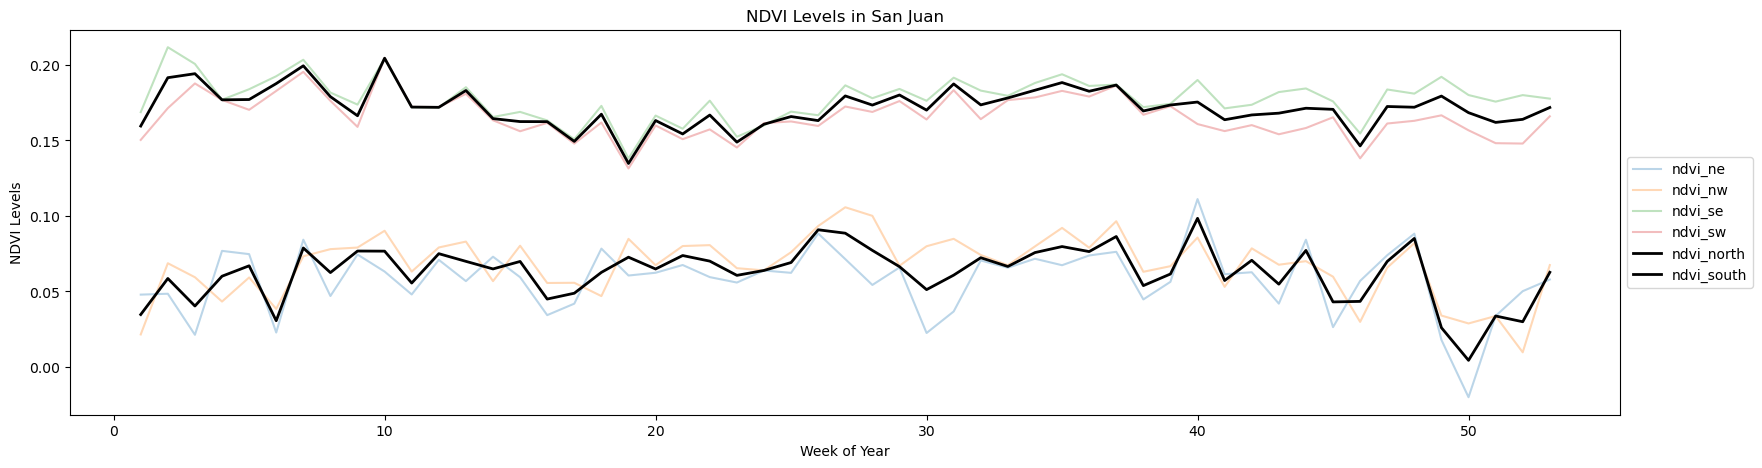

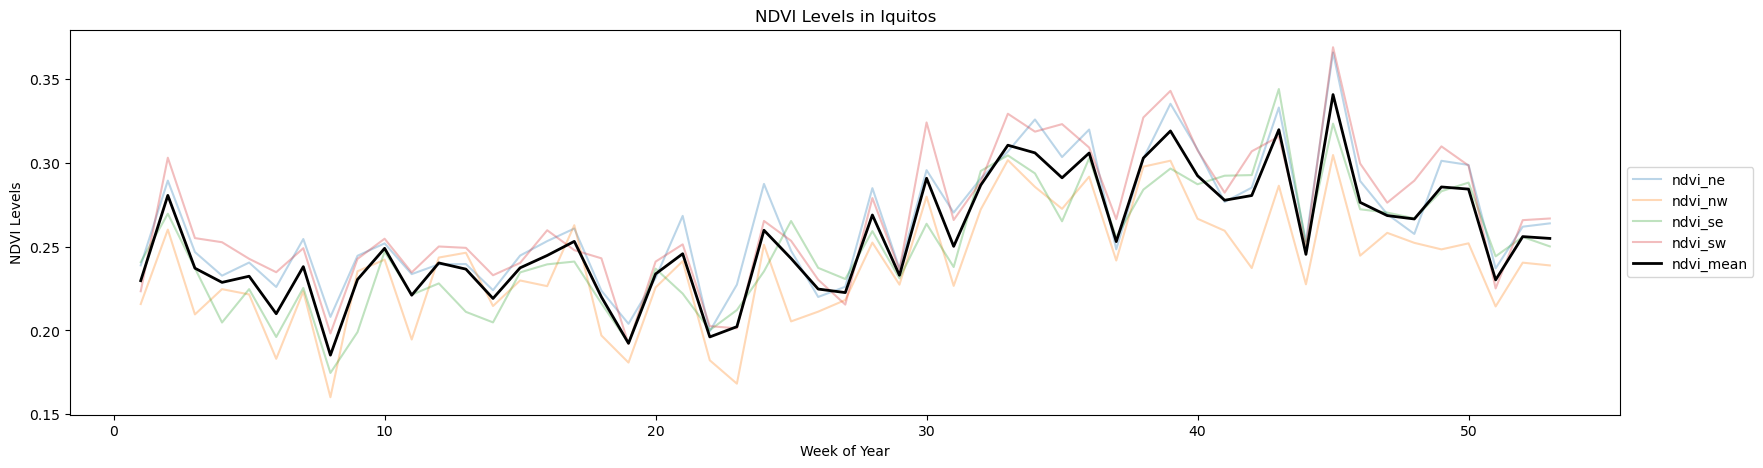

In [27]:
# Visualize the NDVI features 
VizFeatures(dengue_sj, ndvi_features, ndvi_features_mean_sj, "NDVI Levels in San Juan", "NDVI Levels")
VizFeatures(dengue_iq, ndvi_features, ndvi_features_mean_iq, "NDVI Levels in Iquitos", "NDVI Levels")

In [28]:
dengue_sj = dengue_sj.drop("ndvi_ne", axis=1)
dengue_sj = dengue_sj.drop("ndvi_nw", axis=1)
dengue_sj = dengue_sj.drop("ndvi_se", axis=1)
dengue_sj = dengue_sj.drop("ndvi_sw", axis=1)

In [29]:
dengue_sj.head()

year  weekofyear  precipitation_amt_mm  \
week_start_date                                           
1990-04-30       1990          18             -0.519546   
1990-05-07       1990          19             -0.285139   
1990-05-14       1990          20             -0.020980   
1990-05-21       1990          21             -0.453281   
1990-05-28       1990          22             -0.629988   

                 reanalysis_air_temp_k  reanalysis_avg_temp_k  \
week_start_date                                                 
1990-04-30                   -1.291443              -1.263568   
1990-05-07                   -0.773037              -0.686996   
1990-05-14                   -0.310298              -0.328110   
1990-05-21                   -0.143295              -0.039824   
1990-05-28                    0.288131               0.319063   

                 reanalysis_dew_point_temp_k  reanalysis_max_air_temp_k  \
week_start_date                                                           
1990-04-30                         -1.723227                  -1.274760   
1990-05-07                         -0.740438                  -0.397714   
1990-05-14                          0.207643                  -0.716640   
1990-05-21                          0.128180                   0.000943   
1990-05-28                          0.455167                   0.399600   

                 reanalysis_min_air_temp_k  reanalysis_precip_amt_kg_per_m2  \
week_start_date                                                               
1990-04-30                       -1.086811                         0.043234   
1990-05-07                       -0.699170                        -0.352883   
1990-05-14                       -0.001417                        -0.122988   
1990-05-21                       -0.234002                        -0.466703   
1990-05-28                        0.153639                        -0.514597   

                 reanalysis_relative_humidity_percent  ...  \
week_start_date                                        ...   
1990-04-30                                  -1.540655  ...   
1990-05-07                                  -0.355252  ...   
1990-05-14                                   1.031949  ...   
1990-05-21                                   0.523859  ...   
1990-05-28                                   0.560242  ...   

                 reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  \
week_start_date                                                             
1990-04-30                                   -1.633073           0.225954   
1990-05-07                                   -0.758517          -0.291413   
1990-05-14                                    0.190449          -0.435126   
1990-05-21                                    0.077455          -0.176442   
1990-05-28                                    0.422868           1.002004   

                 station_avg_temp_c  station_diur_temp_rng_c  \
week_start_date                                                
1990-04-30                -1.108853                 0.171249   
1990-05-07                -0.207239                -0.463396   
1990-05-14                -0.207239                -0.326176   
1990-05-21                 0.329677                 0.016876   
1990-05-28                 1.373117                 3.138646   

                 station_max_temp_c  station_min_temp_c  station_precip_mm  \
week_start_date                                                              
1990-04-30                -1.290552           -1.733031          -0.369164   
1990-05-07                 0.053799           -0.266984          -0.622451   
1990-05-14                 0.346049            0.132847           0.500224   
1990-05-21                 0.989000            0.466040          -0.779899   
1990-05-28                 1.982650            0.865871          -0.718289   

                 total_cases  ndvi_north  ndvi_south  
week_start_date                          

In [30]:
dengue_iq = dengue_iq.drop("ndvi_ne", axis=1)
dengue_iq = dengue_iq.drop("ndvi_nw", axis=1)
dengue_iq = dengue_iq.drop("ndvi_se", axis=1)
dengue_iq = dengue_iq.drop("ndvi_sw", axis=1)

In [31]:
dengue_iq.head()

year  weekofyear  precipitation_amt_mm  \
week_start_date                                           
2000-07-01       2000          26             -1.108033   
2000-07-08       2000          27             -0.103732   
2000-07-15       2000          28             -0.248956   
2000-07-22       2000          29             -1.673237   
2000-07-29       2000          30             -0.042390   

                 reanalysis_air_temp_k  reanalysis_avg_temp_k  \
week_start_date                                                 
2000-07-01                   -0.969266              -0.515250   
2000-07-08                   -1.059980              -0.531414   
2000-07-15                   -1.247538              -1.312700   
2000-07-22                   -2.155908              -2.190973   
2000-07-29                   -1.232828              -1.129502   

                 reanalysis_dew_point_temp_k  reanalysis_max_air_temp_k  \
week_start_date                                                           
2000-07-01                         -0.218871                   0.091608   
2000-07-08                         -0.095299                  -0.203564   
2000-07-15                          0.092084                  -1.089081   
2000-07-22                         -1.911401                  -1.468589   
2000-07-29                         -1.088939                  -0.034894   

                 reanalysis_min_air_temp_k  reanalysis_precip_amt_kg_per_m2  \
week_start_date                                                               
2000-07-01                        0.140982                        -0.288143   
2000-07-08                       -1.067437                        -0.231992   
2000-07-15                       -0.161123                         0.143076   
2000-07-22                       -2.577962                        -0.672403   
2000-07-29                       -0.825753                        -0.515741   

                 reanalysis_relative_humidity_percent  \
week_start_date                                         
2000-07-01                                   0.500766   
2000-07-08                                   0.654842   
2000-07-15                                   0.955231   
2000-07-22                                  -0.186136   
2000-07-29                                  -0.063292   

                 reanalysis_sat_precip_amt_mm  \
week_start_date                                 
2000-07-01                          -1.108033   
2000-07-08                          -0.103732   
2000-07-15                          -0.248956   
2000-07-22                          -1.673237   
2000-07-29                          -0.042390   

                 reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  \
week_start_date                                                             
2000-07-01                                   -0.309064          -0.114174   
2000-07-08                                   -0.162116           0.454505   
2000-07-15                                    0.016604          -0.747343   
2000-07-22                                   -1.852015          -0.037960   
2000-07-29                                   -1.148056           0.120332   

                 station_avg_temp_c  station_diur_temp_rng_c  \
week_start_date                                                
2000-07-01                -1.274363                 0.141243   
2000-07-08                -0.710950                 0.676758   
2000-07-15                -0.823633                 0.609114   
2000-07-22                -1.988018                -0.022231   
2000-07-29                -1.048998                 0.618133   

                 station_max_temp_c  station_min_temp_c  station_precip_mm  \
week_start_date                                                              
2000-07-01                -1.152020           -0.397543          -0.956011   
2000-07-08                -0.003480           -0.317503          -0.110400   
2000-07-15            

### Weather w.r.t 'weekofyear'

In [32]:
dengue_sj['reanalysis_mean_temp_k'] = dengue_sj[['reanalysis_air_temp_k','reanalysis_avg_temp_k', 
                                     'reanalysis_dew_point_temp_k','reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k']].mean(axis=1)
dengue_iq['reanalysis_mean_temp_k'] = dengue_iq[['reanalysis_air_temp_k','reanalysis_avg_temp_k']].mean(axis=1)
weather_features_mean_sj = ['reanalysis_mean_temp_k']
weather_features_mean_iq = ['reanalysis_mean_temp_k']

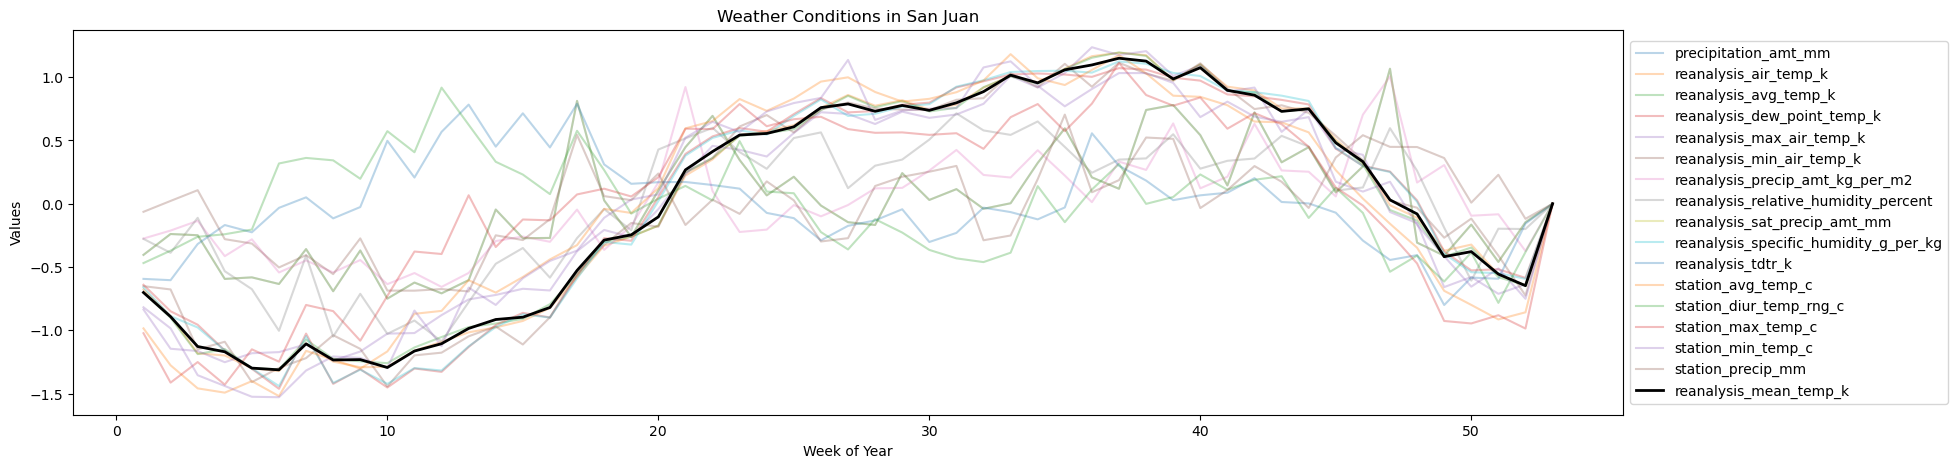

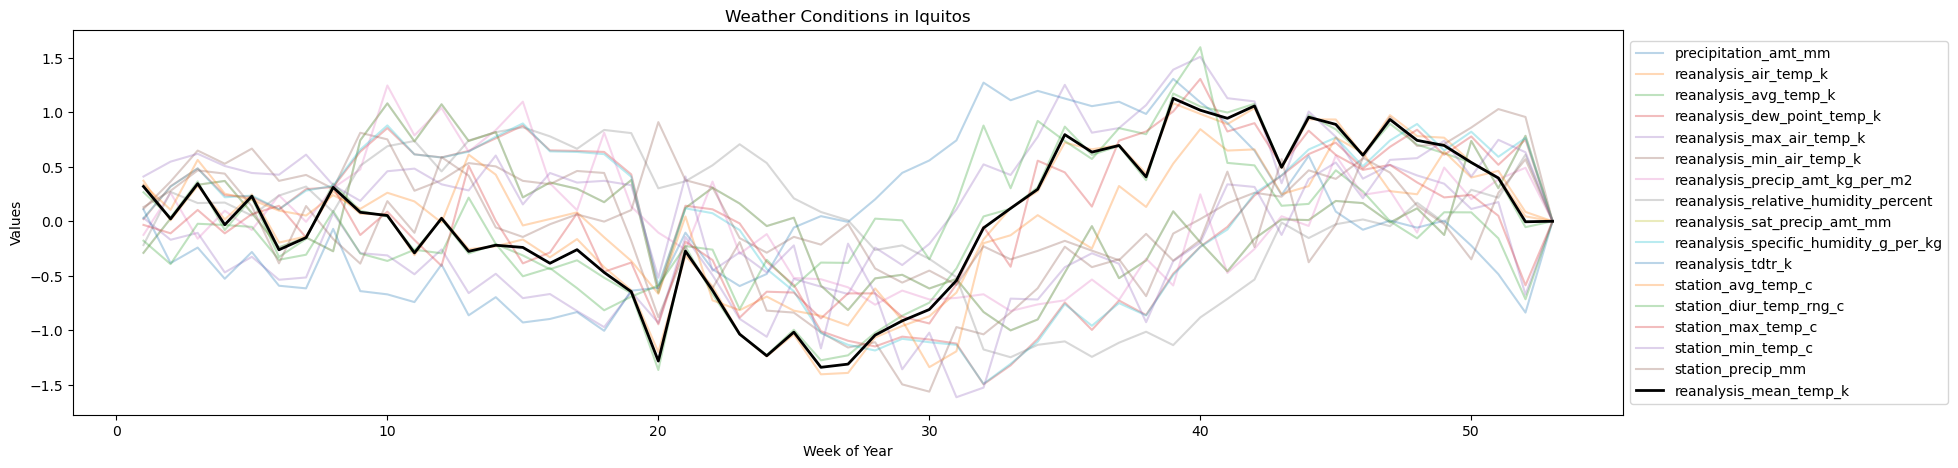

In [33]:
# Visualize the Weather features
VizFeatures(dengue_sj, weather_features, weather_features_mean_sj, "Weather Conditions in San Juan", "Values")
VizFeatures(dengue_iq, weather_features, weather_features_mean_iq, "Weather Conditions in Iquitos", "Values")

In [34]:
dengue_sj = dengue_sj.drop("reanalysis_air_temp_k", axis=1)
dengue_sj = dengue_sj.drop("reanalysis_avg_temp_k", axis=1)
dengue_sj = dengue_sj.drop("reanalysis_dew_point_temp_k", axis=1)
dengue_sj = dengue_sj.drop("reanalysis_max_air_temp_k", axis=1)
dengue_sj = dengue_sj.drop("reanalysis_min_air_temp_k", axis=1)

In [35]:
dengue_sj.head()

year  weekofyear  precipitation_amt_mm  \
week_start_date                                           
1990-04-30       1990          18             -0.519546   
1990-05-07       1990          19             -0.285139   
1990-05-14       1990          20             -0.020980   
1990-05-21       1990          21             -0.453281   
1990-05-28       1990          22             -0.629988   

                 reanalysis_precip_amt_kg_per_m2  \
week_start_date                                    
1990-04-30                              0.043234   
1990-05-07                             -0.352883   
1990-05-14                             -0.122988   
1990-05-21                             -0.466703   
1990-05-28                             -0.514597   

                 reanalysis_relative_humidity_percent  \
week_start_date                                         
1990-04-30                                  -1.540655   
1990-05-07                                  -0.355252   
1990-05-14                                   1.031949   
1990-05-21                                   0.523859   
1990-05-28                                   0.560242   

                 reanalysis_sat_precip_amt_mm  \
week_start_date                                 
1990-04-30                          -0.519546   
1990-05-07                          -0.285139   
1990-05-14                          -0.020980   
1990-05-21                          -0.453281   
1990-05-28                          -0.629988   

                 reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  \
week_start_date                                                             
1990-04-30                                   -1.633073           0.225954   
1990-05-07                                   -0.758517          -0.291413   
1990-05-14                                    0.190449          -0.435126   
1990-05-21                                    0.077455          -0.176442   
1990-05-28                                    0.422868           1.002004   

                 station_avg_temp_c  station_diur_temp_rng_c  \
week_start_date                                                
1990-04-30                -1.108853                 0.171249   
1990-05-07                -0.207239                -0.463396   
1990-05-14                -0.207239                -0.326176   
1990-05-21                 0.329677                 0.016876   
1990-05-28                 1.373117                 3.138646   

                 station_max_temp_c  station_min_temp_c  station_precip_mm  \
week_start_date                                                              
1990-04-30                -1.290552           -1.733031          -0.369164   
1990-05-07                 0.053799           -0.266984          -0.622451   
1990-05-14                 0.346049            0.132847           0.500224   
1990-05-21                 0.989000            0.466040          -0.779899   
1990-05-28                 1.982650            0.865871          -0.718289   

                 total_cases  ndvi_north  ndvi_south  reanalysis_mean_temp_k  
week_start_date                                                               
1990-04-30                 4    0.113162    0.188050               -1.327962  
1990-05-07                 5    0.156037    0.158921               -0.659471  
1990-05-14                 4    0.102608    0.164021               -0.229764  
1990-05-21                 3    0.186850    0.231721               -0.057599  
1990-05-28                 6    0.229200    0.249270                0.323120

In [36]:
dengue_iq = dengue_iq.drop("reanalysis_air_temp_k", axis=1)
dengue_iq = dengue_iq.drop("reanalysis_avg_temp_k", axis=1)

In [37]:
dengue_iq.head()

year  weekofyear  precipitation_amt_mm  \
week_start_date                                           
2000-07-01       2000          26             -1.108033   
2000-07-08       2000          27             -0.103732   
2000-07-15       2000          28             -0.248956   
2000-07-22       2000          29             -1.673237   
2000-07-29       2000          30             -0.042390   

                 reanalysis_dew_point_temp_k  reanalysis_max_air_temp_k  \
week_start_date                                                           
2000-07-01                         -0.218871                   0.091608   
2000-07-08                         -0.095299                  -0.203564   
2000-07-15                          0.092084                  -1.089081   
2000-07-22                         -1.911401                  -1.468589   
2000-07-29                         -1.088939                  -0.034894   

                 reanalysis_min_air_temp_k  reanalysis_precip_amt_kg_per_m2  \
week_start_date                                                               
2000-07-01                        0.140982                        -0.288143   
2000-07-08                       -1.067437                        -0.231992   
2000-07-15                       -0.161123                         0.143076   
2000-07-22                       -2.577962                        -0.672403   
2000-07-29                       -0.825753                        -0.515741   

                 reanalysis_relative_humidity_percent  \
week_start_date                                         
2000-07-01                                   0.500766   
2000-07-08                                   0.654842   
2000-07-15                                   0.955231   
2000-07-22                                  -0.186136   
2000-07-29                                  -0.063292   

                 reanalysis_sat_precip_amt_mm  \
week_start_date                                 
2000-07-01                          -1.108033   
2000-07-08                          -0.103732   
2000-07-15                          -0.248956   
2000-07-22                          -1.673237   
2000-07-29                          -0.042390   

                 reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  \
week_start_date                                                             
2000-07-01                                   -0.309064          -0.114174   
2000-07-08                                   -0.162116           0.454505   
2000-07-15                                    0.016604          -0.747343   
2000-07-22                                   -1.852015          -0.037960   
2000-07-29                                   -1.148056           0.120332   

                 station_avg_temp_c  station_diur_temp_rng_c  \
week_start_date                                                
2000-07-01                -1.274363                 0.141243   
2000-07-08                -0.710950                 0.676758   
2000-07-15                -0.823633                 0.609114   
2000-07-22                -1.988018                -0.022231   
2000-07-29                -1.048998                 0.618133   

                 station_max_temp_c  station_min_temp_c  station_precip_mm  \
week_start_date                                                              
2000-07-01                -1.152020           -0.397543          -0.956011   
2000-07-08                -0.003480           -0.317503          -0.110400   
2000-07-15                -0.769173           -0.397543          -0.391734   
2000-07-22                -1.917713           -5.199954          -0.521952   
2000-07-29                -0.539466           -1.678186          -0.939935   

                 total_cases  ndvi_mean  reanalysis_mean_temp_k  
week_start_date                                                  
2000-07-01                 0   0.228307               -0.742258  
2000-07-08                 0   0.256012      

## Target

**Worked on By: Samiksha Sharma**

In [38]:
# Features now
time_features = ['year', 'weekofyear']
sj_features = ['precipitation_amt_mm', 'reanalysis_precip_amt_kg_per_m2',
            'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
            'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
            'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
            'station_min_temp_c', 'station_precip_mm', 
            'total_cases', 
            'ndvi_north', 'ndvi_south', 
            'reanalysis_mean_temp_k']
iq_features = ['reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
               'precipitation_amt_mm', 'reanalysis_precip_amt_kg_per_m2',
               'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
               'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
               'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
               'station_min_temp_c', 'station_precip_mm', 
               'total_cases', 
               'ndvi_mean', 
               'reanalysis_mean_temp_k']
ndvi_sj_features = ['ndvi_north', 'ndvi_south']
ndvi_iq_features = ['ndvi_mean']
weather_sj_features = ['precipitation_amt_mm', 'reanalysis_precip_amt_kg_per_m2',
                    'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
                    'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
                    'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
                    'station_min_temp_c', 'station_precip_mm','reanalysis_mean_temp_k']
weather_iq_features = ['precipitation_amt_mm', 'reanalysis_precip_amt_kg_per_m2',
                    'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
                    'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
                    'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
                    'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
                    'station_min_temp_c', 'station_precip_mm','reanalysis_mean_temp_k']
target = ['total_cases']

### Target w.r.t NDVI and Weather Features

In [39]:
# Function to check the correlation of target features with NDVI and Weather features
def VisualizeTargetCorrelation(df,title):
    # Create Correlation Matrix
    corr_matrix= df.corr(numeric_only=True)

    # Show Correlation for Total Cases
    plt.figure(figsize=(10, 4))
    corr_matrix[target].drop(target).sort_values(by = target, ascending=False).plot.barh()
    plt.title(title)
    plt.show()

<Figure size 1000x400 with 0 Axes>

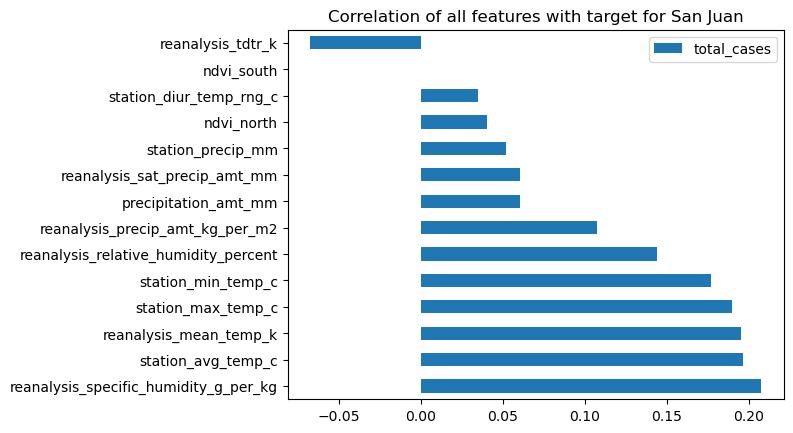

<Figure size 1000x400 with 0 Axes>

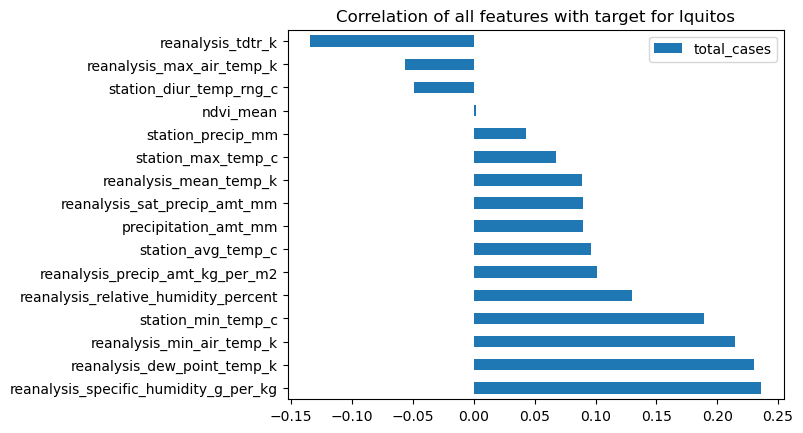

In [40]:
# Visualize the correlation of target with NDVI and Weather features
VisualizeTargetCorrelation(dengue_sj[sj_features], "Correlation of all features with target for San Juan")
VisualizeTargetCorrelation(dengue_iq[iq_features], "Correlation of all features with target for Iquitos")

### Target w.r.t 'year' and 'weekofyear'

In [41]:
# Function to visualize the total cases w.r.t 'year' and 'weekofyear'
def VizTarget1(df,title):
    df2 = df
    df2 = df2.reset_index()
    df2 = df2.set_index(['year','weekofyear'], drop=True)
    df2[target].plot(figsize = (10,4))
    plt.title(title)
    plt.xlabel("Year, Week of Year")
    plt.ylabel("Number of Cases")
    plt.show()

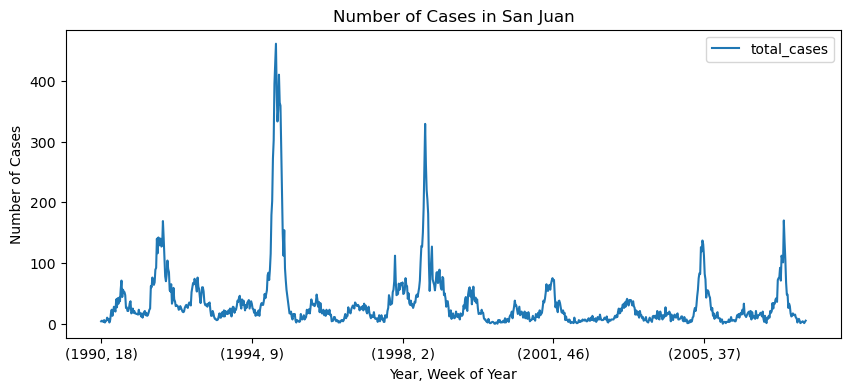

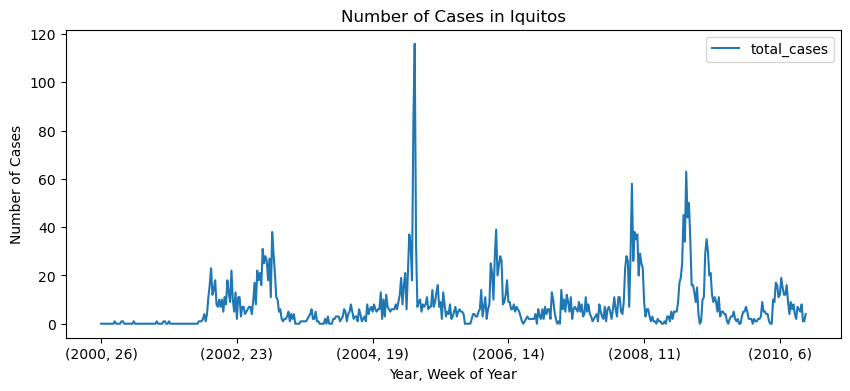

In [42]:
# Visualize the total cases w.r.t 'year' and 'weekofyear'
VizTarget1(dengue_sj,"Number of Cases in San Juan")
VizTarget1(dengue_iq,"Number of Cases in Iquitos")

In [43]:
# Function to visualize the decomposed target values
def VizDecomposedTarget(df):
    # Perform seasonal decomposition
    decomposition = seasonal_decompose(df[target], model='additive', period=52)

    # Plot the decomposition
    plt.figure(figsize=(15, 10))
    decomposition.plot()
    plt.show()

For San Juan:


<Figure size 1500x1000 with 0 Axes>

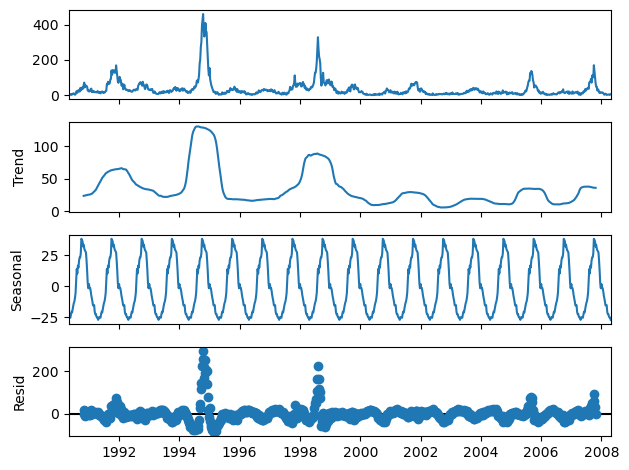

For Iquitos:


<Figure size 1500x1000 with 0 Axes>

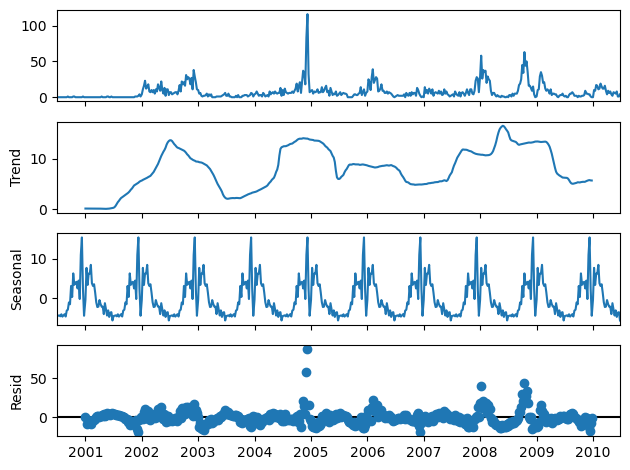

In [44]:
# Visualize the decomposed target values
print("For San Juan:")
VizDecomposedTarget(dengue_sj)
print("For Iquitos:")
VizDecomposedTarget(dengue_iq)

### Target w.r.t 'weekofyear' for all years

In [45]:
# Function to visualize the total cases w.r.t 'weekofyear' for all years
def VizTarget2(df, title):
    df2 = df
    df2 = df2.reset_index()
    df2 = df2.set_index(['year','weekofyear'], drop=True)
    # Find all unique values in the first level of the index
    unique_years = df2.index.get_level_values(0).unique()
    for i in unique_years:
        df3 = df2.loc[i]
        plt.plot(df3[target], alpha = .3)

    df2.groupby('weekofyear')['total_cases'].mean().plot(c = 'k', figsize = (10,4))
    plt.legend(unique_years, loc='center left', bbox_to_anchor=(1, .5))
    plt.title(title)
    plt.xlabel('Week of the Year')
    plt.ylabel('Number of Cases')
    plt.show()

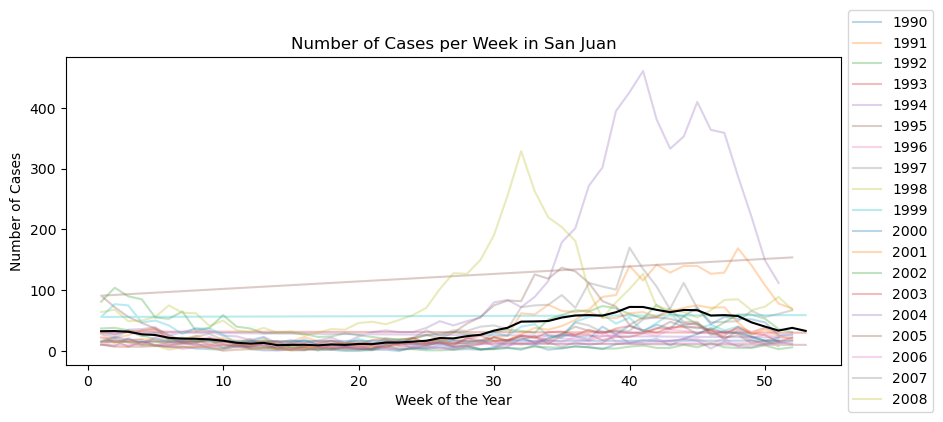

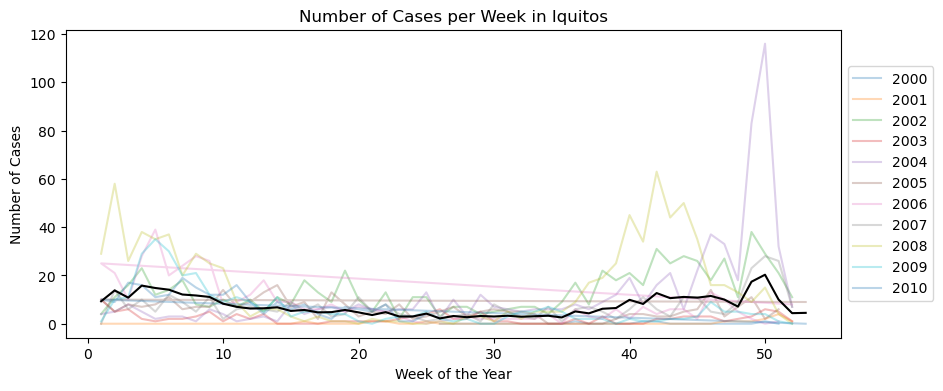

In [46]:
# Visualize the total cases w.r.t 'weekofyear' for all years
VizTarget2(dengue_sj, "Number of Cases per Week in San Juan")
VizTarget2(dengue_iq, "Number of Cases per Week in Iquitos")

# Training Data Modelling and Testing

## Split Training Dataset into Train Data for Modeling and Test Data for Testing

**Worked on By: Vaishali Gupta**

In [47]:
# Split San Juan Dataset
dengue_sj.sort_index()

X_sj = dengue_sj.drop(columns=target, axis=1)
y_sj = dengue_sj[target]

sj_train_start_index = dengue_sj.index[0]
sj_train_end_index = dengue_sj.index[(int(len(dengue_sj)*0.7))+3]
sj_test_start_index = dengue_sj.index[(int(len(dengue_sj)*0.7))+4]
sj_test_end_index = dengue_sj.index[-1]

dengue_sj_train = dengue_sj.loc[sj_train_start_index:sj_train_end_index]
X_sj_train = dengue_sj_train.drop(columns=target, axis=1)
y_sj_train = dengue_sj_train[target]

dengue_sj_test = dengue_sj.loc[sj_test_start_index:sj_test_end_index]
X_sj_test = dengue_sj_test.drop(columns=target, axis=1)
y_sj_test = dengue_sj_test[target]

In [48]:
# Split Iquitos Dataset
dengue_iq.sort_index()

X_iq = dengue_iq.drop(columns=target, axis=1)
y_iq = dengue_iq[target]

iq_train_start_index = dengue_iq.index[0]
iq_train_end_index = dengue_iq.index[(int(len(dengue_iq)*0.7))+4]
iq_test_start_index = dengue_iq.index[(int(len(dengue_iq)*0.7))+5]
iq_test_end_index = dengue_iq.index[-1]

dengue_iq_train = dengue_iq.loc[iq_train_start_index:iq_train_end_index]
X_iq_train = dengue_iq_train.drop(columns=target, axis=1)
y_iq_train = dengue_iq_train[target]

dengue_iq_test = dengue_iq.loc[iq_test_start_index:iq_test_end_index]
X_iq_test = dengue_iq_test.drop(columns=target, axis=1)
y_iq_test = dengue_iq_test[target]

## Regression Modeling and Testing

**Worked on By: Vaishali Gupta, Samiksha Sharma, and Shweta Bhati**

We worked to test each model separately on our training data to study it and learn how it works.

* Linear Regression - Vaishali Gupta
* Random Forest Regression, Support Vector Machine - Samiksha Sharma
* Gradient Boost Regression and Neural Network - Shweta Bhati

General function "FitModelandEvaluate" - Smaiksha Sharma

General function "VizMSEValues" - Shweta Bhati

General function "VizPredictedvsActual" - Vaishali Gupta

In [49]:
def FitModelandEvaluate(model, param_grid, X_train, y_train):
    # Define k-folds for Cross Validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Define mean squared error as the scoring metric
    scoring = make_scorer(mean_squared_error, greater_is_better=False)
    
    # Perform GridSearchCV with K-fold cross-validation for hyperparameter tuning
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, error_score='raise', cv=kf)
    grid_result = grid.fit(X_train, y_train)

    # Get the best model
    best_model = grid_result.best_estimator_

    # Evaluate the best model using cross-validation
    cv_results = grid_result.cv_results_
    print("Cross-validation results:")
    for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
        print(f"Mean MSE: {-mean_score:.4f}, Params: {params}")

    # You can also extract the best parameters and the corresponding MSE
    best_params = grid_result.best_params_
    best_mse = -grid_result.best_score_
    print("\nBest Parameters:", best_params)
    print("Best Mean MSE:", best_mse)
    return best_mse, best_params, best_model

In [50]:
# Initalize different Regression Models and their parameter grids

# Initialize the linear regression model
model_1 = LinearRegression()
# Define hyperparameters grid for tuning
param_grid_1 = {}

# Initialize the Random Forest regression model
model_2 = RandomForestRegressor(random_state=42)
# Define hyperparameters grid for tuning
param_grid_2 = {
    'n_estimators': [100, 200, 300]
}

# Initialize the Gradient Boosting regression model
model_3 = GradientBoostingRegressor(random_state=42)
# Define hyperparameters grid for tuning
param_grid_3 = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Initialize the SVR model
model_4 = SVR()
# Define hyperparameters grid for tuning
param_grid_4 = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1, 10]
}

# Define the neural network model for San Juan
def create_model_sj(neurons=1, activation='tanh', optimizer='adam'):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(X_sj.shape[1],)))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(1)) 
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

def create_model_iq(neurons=1, activation='tanh', optimizer='adam'):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(X_iq.shape[1],)))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(1)) 
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model
    
# Create KerasRegressor wrapper for scikit-learn
model_sj_5 = KerasRegressor(build_fn=create_model_sj, verbose=0)
model_iq_5 = KerasRegressor(build_fn=create_model_iq, verbose=0)
# Define hyperparameters grid for tuning
param_grid_5 = {
    'neurons': [10, 50, 100],
    'optimizer': ['adam', 'sgd']
}

In [51]:
#Visualise all MSE values on the graph for comparison to choose the best model
def VizMSEValues(mse_1, mse_2, mse_3, mse_4, mse_5, param_1, param_2, param_3, param_4, param_5, model_1, model_2, model_3, model_4, model_5):
    mse_values = PrettyTable(["Model", "MSE", "Parameters"])
    mse_values.add_row(['Linear Regression', mse_1, param_1])
    mse_values.add_row(['Random Forest Regression', mse_2, param_2])
    mse_values.add_row(['Gradient Boost Regression', mse_3, param_3])
    mse_values.add_row(['Support Vector Regression', mse_4, param_4])
    mse_values.add_row(['Neural Network Regression', mse_5, param_5])
    
    print(mse_values)

    mse_table= pd.DataFrame([['Linear Regression', mse_1, model_1],
                              ['RandomForest Regression', mse_2, model_2], 
                              ['Gradient Boost Regression',mse_3, model_3],
                              ['Support Vector Regression', mse_4, model_4], 
                              ['Neural Network Regression', mse_5, model_5]])
    
    
    plt.figure(figsize=(12,3))
    plt.scatter(mse_table[0], mse_table[1],  color='blue')
    plt.plot(mse_table[0], mse_table[1], color='red', linestyle='-', linewidth=1)
    plt.xlabel('Models')
    plt.ylabel('MSE')
    plt.title('MSE Values for all Regression Models')
    plt.show()

    best_model = mse_table[mse_table[1]==min(mse_table[1])]
    return best_model

In [52]:
# Plotting the actual vs predicted values
def VizPredictedvsActual(y_pred, y_test, title):
    plt.figure(figsize=(15, 5))
    y_pred['predicted_cases'].plot(label='Predictions', color='blue', marker='o')
    y_test['total_cases'].plot(label='Actual Values', color='red', marker='x')
    plt.title(title)
    
    plt.xlabel('Year')
    plt.ylabel('Total Cases')
    plt.legend()
    plt.grid(True)
    plt.show()

### San Juan

In [53]:
print("Linear Regression:")
mse_sj_1, params_sj_1, model_sj_1 = FitModelandEvaluate(model_1, param_grid_1, X_sj_train, y_sj_train)

Linear Regression:
Cross-validation results:
Mean MSE: 3078.0490, Params: {}

Best Parameters: {}
Best Mean MSE: 3078.049006053493


In [54]:
print("Random Forest Regression:")
mse_sj_2, params_sj_2, model_sj_2 = FitModelandEvaluate(model_2, param_grid_2, X_sj_train, y_sj_train)

Random Forest Regression:
Cross-validation results:
Mean MSE: 1256.7336, Params: {'n_estimators': 100}
Mean MSE: 1280.5121, Params: {'n_estimators': 200}
Mean MSE: 1309.0421, Params: {'n_estimators': 300}

Best Parameters: {'n_estimators': 100}
Best Mean MSE: 1256.7335547779319


In [55]:
print("Gradient Boost Regression:")
mse_sj_3, params_sj_3, model_sj_3 = FitModelandEvaluate(model_3, param_grid_3, X_sj_train, y_sj_train)

Gradient Boost Regression:
Cross-validation results:
Mean MSE: 2228.1472, Params: {'learning_rate': 0.01, 'n_estimators': 50}
Mean MSE: 1837.6098, Params: {'learning_rate': 0.01, 'n_estimators': 100}
Mean MSE: 1653.3843, Params: {'learning_rate': 0.01, 'n_estimators': 150}
Mean MSE: 1305.0306, Params: {'learning_rate': 0.1, 'n_estimators': 50}
Mean MSE: 1273.2387, Params: {'learning_rate': 0.1, 'n_estimators': 100}
Mean MSE: 1229.5955, Params: {'learning_rate': 0.1, 'n_estimators': 150}
Mean MSE: 1234.2072, Params: {'learning_rate': 0.2, 'n_estimators': 50}
Mean MSE: 1208.9408, Params: {'learning_rate': 0.2, 'n_estimators': 100}
Mean MSE: 1214.0085, Params: {'learning_rate': 0.2, 'n_estimators': 150}

Best Parameters: {'learning_rate': 0.2, 'n_estimators': 100}
Best Mean MSE: 1208.9408356670974


In [56]:
print("Support Vector Regression:")
mse_sj_4, params_sj_4, model_sj_4 = FitModelandEvaluate(model_4, param_grid_4, X_sj_train, y_sj_train)

Support Vector Regression:
Cross-validation results:
Mean MSE: 3402.2634, Params: {'C': 0.1, 'kernel': 'linear'}
Mean MSE: 3614.8880, Params: {'C': 0.1, 'kernel': 'rbf'}
Mean MSE: 3614.8384, Params: {'C': 0.1, 'kernel': 'poly'}
Mean MSE: 3381.4930, Params: {'C': 1, 'kernel': 'linear'}
Mean MSE: 3614.2233, Params: {'C': 1, 'kernel': 'rbf'}
Mean MSE: 3613.7250, Params: {'C': 1, 'kernel': 'poly'}
Mean MSE: 3278.8295, Params: {'C': 10, 'kernel': 'linear'}
Mean MSE: 3607.5610, Params: {'C': 10, 'kernel': 'rbf'}
Mean MSE: 3601.8027, Params: {'C': 10, 'kernel': 'poly'}

Best Parameters: {'C': 10, 'kernel': 'linear'}
Best Mean MSE: 3278.829490011085


In [57]:
print("Neural Netwrok Regression:")
mse_sj_5, params_sj_5, model_sj_5 = FitModelandEvaluate(model_sj_5, param_grid_5, X_sj_train, y_sj_train)

Neural Netwrok Regression:
Cross-validation results:
Mean MSE: 4825.6832, Params: {'neurons': 10, 'optimizer': 'adam'}
Mean MSE: 3388.2673, Params: {'neurons': 10, 'optimizer': 'sgd'}
Mean MSE: 4596.0405, Params: {'neurons': 50, 'optimizer': 'adam'}
Mean MSE: 3487.2129, Params: {'neurons': 50, 'optimizer': 'sgd'}
Mean MSE: 4211.5672, Params: {'neurons': 100, 'optimizer': 'adam'}
Mean MSE: 6379.7685, Params: {'neurons': 100, 'optimizer': 'sgd'}

Best Parameters: {'neurons': 10, 'optimizer': 'sgd'}
Best Mean MSE: 3388.267266782819


+---------------------------+--------------------+---------------------------------------------+
|           Model           |        MSE         |                  Parameters                 |
+---------------------------+--------------------+---------------------------------------------+
|     Linear Regression     | 3078.049006053493  |                      {}                     |
|  Random Forest Regression | 1256.7335547779319 |            {'n_estimators': 100}            |
| Gradient Boost Regression | 1208.9408356670974 | {'learning_rate': 0.2, 'n_estimators': 100} |
| Support Vector Regression | 3278.829490011085  |        {'C': 10, 'kernel': 'linear'}        |
| Neural Network Regression | 3388.267266782819  |     {'neurons': 10, 'optimizer': 'sgd'}     |
+---------------------------+--------------------+---------------------------------------------+


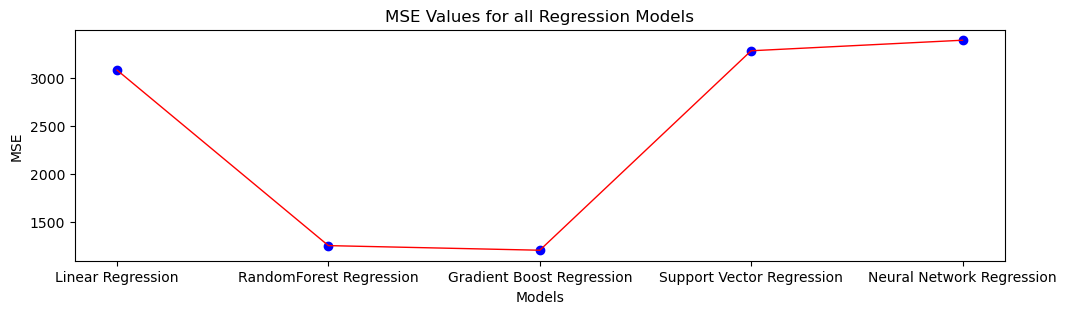

In [58]:
# Visualize the mse values
best_model_sj = VizMSEValues(mse_sj_1, mse_sj_2, mse_sj_3, mse_sj_4, mse_sj_5, 
             params_sj_1, params_sj_2, params_sj_3, params_sj_4, params_sj_5, 
             model_sj_1, model_sj_2, model_sj_3, model_sj_4, model_sj_5)

In [59]:
# Best Chosen Model
regression_model = best_model_sj[2][2]
regression_model

GradientBoostingRegressor(learning_rate=0.2, random_state=42)

In [60]:
# Make predictions with best chosen model
y_sj_predictions = pd.Series(regression_model.predict(X_sj_test))

In [61]:
y_sj_predictions = y_sj_predictions.astype(int)
y_sj_predictions.index = y_sj_test.index
y_sj_predictions = y_sj_predictions.to_frame(name='predicted_cases')

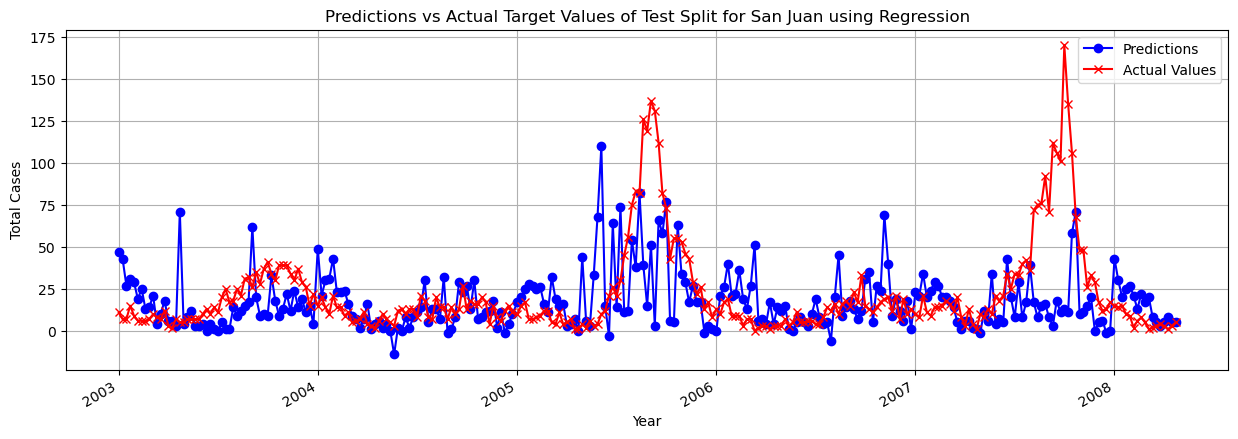

In [62]:
# Vizualize the Actual vs Predicted Number of Cases on the Test Split of San Juan
VizPredictedvsActual (y_sj_predictions, y_sj_test, "Predictions vs Actual Target Values of Test Split for San Juan using Regression")

In [63]:
# Evaluate the Best Model
mse_sj = mean_squared_error(y_sj_predictions, y_sj_test)
print("MSE for the Gradient Boost Regression model for San Juan Dataset: ", mse_sj)

MSE for the Gradient Boost Regression model for San Juan Dataset:  797.8628158844765


### Iquitos

In [64]:
print("Linear Regression:")
mse_iq_1, params_iq_1, model_iq_1 = FitModelandEvaluate(model_1, param_grid_1, X_iq_train, y_iq_train)

Linear Regression:
Cross-validation results:
Mean MSE: 96.4346, Params: {}

Best Parameters: {}
Best Mean MSE: 96.43464197780705


In [65]:
print("Random Forest Regression:")
mse_iq_2, params_iq_2, model_iq_2 = FitModelandEvaluate(model_2, param_grid_2, X_iq_train, y_iq_train)

Random Forest Regression:
Cross-validation results:
Mean MSE: 94.9760, Params: {'n_estimators': 100}
Mean MSE: 93.2084, Params: {'n_estimators': 200}
Mean MSE: 91.8286, Params: {'n_estimators': 300}

Best Parameters: {'n_estimators': 300}
Best Mean MSE: 91.8286424048706


In [66]:
print("Gradient Boost Regression:")
mse_iq_3, params_iq_3, model_iq_3 = FitModelandEvaluate(model_3, param_grid_3, X_iq_train, y_iq_train)

Gradient Boost Regression:
Cross-validation results:
Mean MSE: 97.9838, Params: {'learning_rate': 0.01, 'n_estimators': 50}
Mean MSE: 100.8083, Params: {'learning_rate': 0.01, 'n_estimators': 100}
Mean MSE: 100.6957, Params: {'learning_rate': 0.01, 'n_estimators': 150}
Mean MSE: 112.0898, Params: {'learning_rate': 0.1, 'n_estimators': 50}
Mean MSE: 112.7314, Params: {'learning_rate': 0.1, 'n_estimators': 100}
Mean MSE: 113.0977, Params: {'learning_rate': 0.1, 'n_estimators': 150}
Mean MSE: 112.9075, Params: {'learning_rate': 0.2, 'n_estimators': 50}
Mean MSE: 115.2394, Params: {'learning_rate': 0.2, 'n_estimators': 100}
Mean MSE: 115.9923, Params: {'learning_rate': 0.2, 'n_estimators': 150}

Best Parameters: {'learning_rate': 0.01, 'n_estimators': 50}
Best Mean MSE: 97.98382089212305


In [67]:
print("Support Vector Regression:")
mse_iq_4, params_iq_4, model_iq_4 = FitModelandEvaluate(model_4, param_grid_4, X_iq_train, y_iq_train)

Support Vector Regression:
Cross-validation results:
Mean MSE: 104.9882, Params: {'C': 0.1, 'kernel': 'linear'}
Mean MSE: 106.1728, Params: {'C': 0.1, 'kernel': 'rbf'}
Mean MSE: 106.1734, Params: {'C': 0.1, 'kernel': 'poly'}
Mean MSE: 102.0880, Params: {'C': 1, 'kernel': 'linear'}
Mean MSE: 106.1825, Params: {'C': 1, 'kernel': 'rbf'}
Mean MSE: 106.1892, Params: {'C': 1, 'kernel': 'poly'}
Mean MSE: 118.4618, Params: {'C': 10, 'kernel': 'linear'}
Mean MSE: 106.2840, Params: {'C': 10, 'kernel': 'rbf'}
Mean MSE: 106.3291, Params: {'C': 10, 'kernel': 'poly'}

Best Parameters: {'C': 1, 'kernel': 'linear'}
Best Mean MSE: 102.08797190222631


In [68]:
print("Neural Network Regression:")
mse_iq_5, params_iq_5, model_iq_5 = FitModelandEvaluate(model_iq_5, param_grid_5, X_iq_train, y_iq_train)

Neural Network Regression:
Cross-validation results:
Mean MSE: 135.4451, Params: {'neurons': 10, 'optimizer': 'adam'}
Mean MSE: 101.6175, Params: {'neurons': 10, 'optimizer': 'sgd'}
Mean MSE: 114.1093, Params: {'neurons': 50, 'optimizer': 'adam'}
Mean MSE: 100.6007, Params: {'neurons': 50, 'optimizer': 'sgd'}
Mean MSE: 101.0265, Params: {'neurons': 100, 'optimizer': 'adam'}
Mean MSE: 160.2110, Params: {'neurons': 100, 'optimizer': 'sgd'}

Best Parameters: {'neurons': 50, 'optimizer': 'sgd'}
Best Mean MSE: 100.60067155215398


+---------------------------+--------------------+---------------------------------------------+
|           Model           |        MSE         |                  Parameters                 |
+---------------------------+--------------------+---------------------------------------------+
|     Linear Regression     | 96.43464197780705  |                      {}                     |
|  Random Forest Regression |  91.8286424048706  |            {'n_estimators': 300}            |
| Gradient Boost Regression | 97.98382089212305  | {'learning_rate': 0.01, 'n_estimators': 50} |
| Support Vector Regression | 102.08797190222631 |         {'C': 1, 'kernel': 'linear'}        |
| Neural Network Regression | 100.60067155215398 |     {'neurons': 50, 'optimizer': 'sgd'}     |
+---------------------------+--------------------+---------------------------------------------+


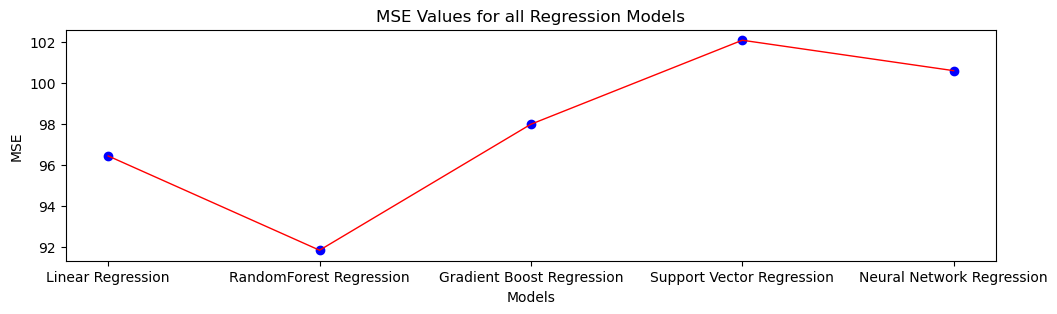

In [69]:
# Visualize the mse values
best_model_iq = VizMSEValues(mse_iq_1, mse_iq_2, mse_iq_3, mse_iq_4, mse_iq_5, 
                             params_iq_1, params_iq_2, params_iq_3, params_iq_4, params_iq_5,
                             model_iq_1, model_iq_2, model_iq_3, model_iq_4, model_iq_5)

In [70]:
# Best chosen model
regression_model_2 = best_model_iq[2][1]

In [71]:
# Make predictions with the best chosen model
y_iq_predictions = pd.Series(regression_model_2.predict(X_iq_test))

In [72]:
y_iq_predictions = y_iq_predictions.astype(int)
y_iq_predictions.index = y_iq_test.index
y_iq_predictions = y_iq_predictions.to_frame(name='predicted_cases')

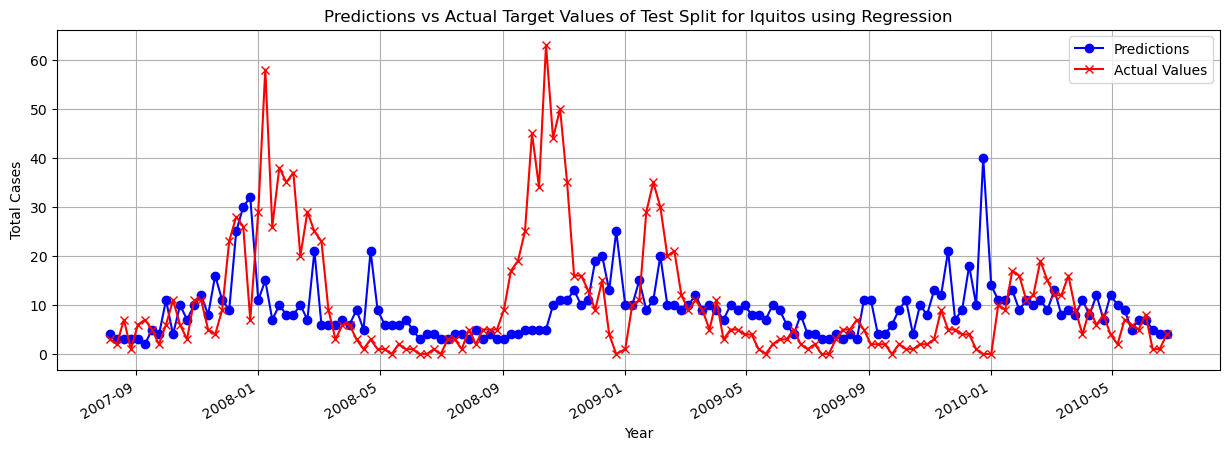

In [73]:
# Vizualize the Actual vs Predicted Number of Cases on the Test Split of Iquitos
VizPredictedvsActual(y_iq_predictions, y_iq_test, "Predictions vs Actual Target Values of Test Split for Iquitos using Regression")

In [74]:
# Evaluate the Best Model
mse_iq = mean_squared_error(y_iq_predictions, y_iq_test)
print("MSE for the Random forest Regression model for Iquitos Dataset: ", mse_iq)

MSE for the Random forest Regression model for Iquitos Dataset:  156.26490066225165


## Time Series Modelling

**Worked on By: Vaishali Gupta, Samiksha Sharma, and Shweta Bhati**

We worked to test each model separately on our training data to study it and learn how it works.

* ARIMA - Vaishali Gupta
* Negative Binomial - Samiksha Sharma
* Prophet - Shweta Bhati

General functions "BestParamARIMA", "VizPredictedvsActualARIMA" - Vaishali Gupta

General functions "GetStatsNegBinomialModel", "VizPredictedvsActualStatsNegBin" - Samiksha Sharma

General functions "GetProphet", "VizPredictedvsActualProphet" - Shweta Bhati

General function "VizMSEValues2" - Samiksha Sharma

In [75]:
#function to get the best parameters for ARIMA model
def BestParamARIMA(y_train):
    # Define the range of values for p, d, and q
    p_values = range(0, 3) 
    d_values = range(0, 3) 
    q_values = range(0, 3) 

    # Generate all possible combinations of p, d, and q
    pdq_values = list(itertools.product(p_values, d_values, q_values))

    # Evaluate each combination using AIC or BIC and select the best one
    best_aic = float("inf")
    best_params = None

    for pdq in pdq_values:
        try:
            model = ARIMA(y_train, order=pdq)
            model_fit = model.fit()
            aic = model_fit.aic
            if aic < best_aic:
                best_aic = aic
                best_params = pdq
        except:
            continue
    print("Best ARIMA parameters:", best_params)
    print("Best AIC:", best_aic)
    return best_params

In [76]:
#function to visualize actual and predicted values
def VizPredictedvsActualARIMA(y_pred, y_test, title):
    plt.figure(figsize=(15, 5))
    y_pred['predicted_mean'].plot(label='Predictions', color='blue', marker='X')
    y_test['total_cases'].plot(label='Actual Values', color='red', marker='x')
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel('Total Cases')
    plt.legend()
    plt.grid(True)
    plt.show()

In [77]:
#function to get the best parameters for Negative Binomial model
def GetStatsNegBinomialModel(train, test, model_formula):
    grid = 10 ** np.arange(-8, -3, dtype=np.float64)
                    
    best_alpha = []
    best_score = 1000
        
    # Find the best hyper parameter, alpha
    for alpha in grid:
        model = smf.glm(formula=model_formula,
                        data=train,
                        family=sm.families.NegativeBinomial(alpha=alpha))

        results = model.fit()
        predictions = results.predict(test).astype(int)
        score = eval_measures.meanabs(predictions, test.total_cases)

        if score < best_score:
            best_alpha = alpha
            best_score = score

    print('best alpha = ', best_alpha)
    print('best score = ', best_score)
            
    # Refit on entire dataset
    full_dataset = pd.concat([train, test])
    model = smf.glm(formula=model_formula,
                    data=full_dataset,
                    family=sm.families.NegativeBinomial(alpha=best_alpha))

    fitted_model = model.fit()
    return fitted_model

In [78]:
#function to visualize actual and predicted values
def VizPredictedvsActualStatsNegBin(df, best_model, title):
    figs, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,10))
    df['fitted'] = best_model.fittedvalues
    df.fitted.plot(ax=axes, label="Predictions")
    df.total_cases.plot(ax=axes, label="Actual")
    plt.xlabel("Year")
    plt.ylabel("Total Cases")
    plt.title(title)
    plt.show()

In [79]:
#function to get the best parameters for Prophet model
def GetProphet(df):
    df2 = df
    df2 = df2.reset_index()
    df2.rename(columns={'week_start_date': 'ds','total_cases': 'y'}, inplace=True)

    # Initialize and fit the Prophet model
    model = Prophet()
    model.fit(df2)
    return model

In [80]:
#function to visualize actual and predicted values 
def VizPredictedvsActualProphet(y_pred, y_test, title):
    plt.figure(figsize=(15, 5))
    y_pred['yhat'].plot(label='Predictions', color='blue', marker='X')
    y_test['total_cases'].plot(label='Actual Values', color='red', marker='x')
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel('Total Cases')
    plt.legend()
    plt.grid(True)
    plt.show()

In [113]:
#visualise to compare MSE values and choose the best model
def VizMSEValues2(mse_1, mse_2, mse_3, model_1, model_2, model_3):
    mse_values = PrettyTable(["Model", "MSE"])
    mse_values.add_row(['ARIMA', mse_1])
    mse_values.add_row(['Stats Negative Binomial', mse_2])
    mse_values.add_row(['Prophet', mse_3])
    
    print(mse_values)

    mse_table= pd.DataFrame([['ARIMA', mse_1, model_1],
                             ['Stats Negative Binomial', mse_2, model_2],
                             ['Prophet', mse_3, model_3]])
    
    
    plt.figure(figsize=(12,3))
    plt.scatter(mse_table[0], mse_table[1],  color='blue')
    plt.plot(mse_table[0], mse_table[1], color='red', linestyle='-', linewidth=1)
    plt.xlabel('Models')
    plt.ylabel('MSE')
    plt.title('MSE Values for all Statistical Models')
    plt.show()

    best_model = mse_table[mse_table[1]==min(mse_table[1])]
    return best_model

### San Juan

In [82]:
# ARIMA

# Find the best parameters for ARIMA 
best_param_sj = BestParamARIMA(y_sj_train)

Best ARIMA parameters: (2, 0, 1)
Best AIC: 5390.120308906365


In [83]:
# Fit the ARIMA model with best parameters
arima_model_sj = ARIMA(y_sj_train, order=best_param_sj)
arima_model_sj_fit = arima_model_sj.fit()
print(arima_model_sj_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            total_cases   No. Observations:                  659
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -2690.060
Date:                Wed, 08 May 2024   AIC                           5390.120
Time:                        23:56:32   BIC                           5412.574
Sample:                             0   HQIC                          5398.824
                                - 659                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.4432     12.825      3.075      0.002      14.306      64.580
ar.L1          1.8426      0.031     59.744      0.000       1.782       1.903
ar.L2         -0.8582      0.030    -28.931      0.0

In [84]:
# Making Predictions
y_sj_pred = arima_model_sj_fit.forecast(steps=len(y_sj_test))
y_sj_pred.index = y_sj_test.index
y_sj_pred = pd.DataFrame(y_sj_pred)
y_sj_pred['predicted_mean'] = y_sj_pred['predicted_mean'].astype(int)

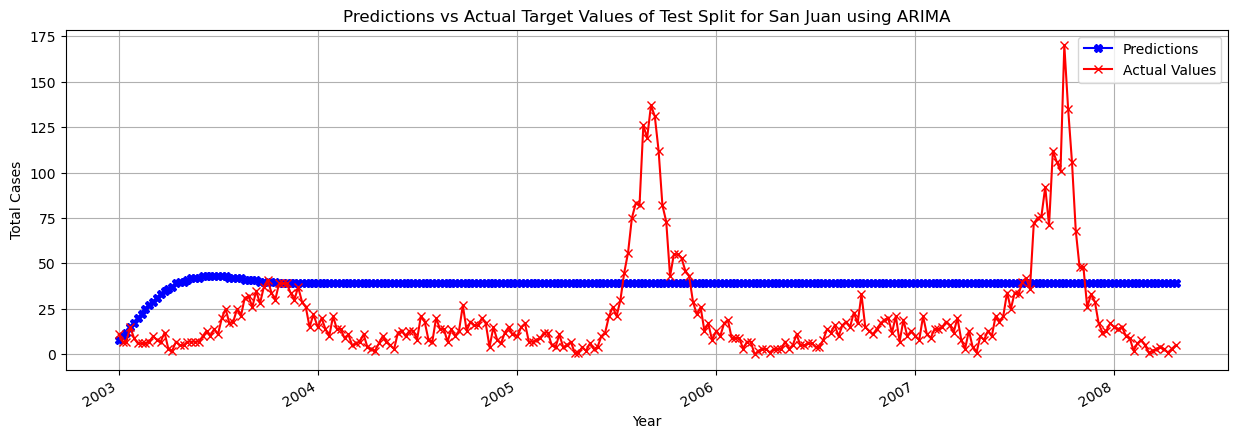

In [85]:
# Visualize Predictions
VizPredictedvsActualARIMA(y_sj_pred, y_sj_test, "Predictions vs Actual Target Values of Test Split for San Juan using ARIMA")

In [86]:
# Evaluate the Predictions
mse_sj_t1 = mean_squared_error(y_sj_pred['predicted_mean'], y_sj_test['total_cases'])
print("MSE for the ARIMA TIme Series model for San Juan Dataset: ", mse_sj_t1)

MSE for the ARIMA TIme Series model for San Juan Dataset:  994.1083032490975


In [87]:
# Stats Negative Binomial

# Specify the formule of the model for Stats Negative Binomial
model_formula_sj = "total_cases ~ 1 +" \
                    "reanalysis_specific_humidity_g_per_kg +" \
                    "station_avg_temp_c +" \
                    "reanalysis_mean_temp_k"

# Fit Stats Negative Binomial Model for best parameters
stats_model_sj = GetStatsNegBinomialModel(dengue_sj_train, dengue_sj_test,model_formula_sj)

best alpha =  1e-08
best score =  26.779783393501805


In [88]:
# Best Stats Model summary
print(stats_model_sj.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            total_cases   No. Observations:                  936
Model:                            GLM   Df Residuals:                      932
Model Family:        NegativeBinomial   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -20270.
Date:                Wed, 08 May 2024   Deviance:                       36084.
Time:                        23:56:54   Pearson chi2:                 6.14e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.9739
Covariance Type:            nonrobust                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

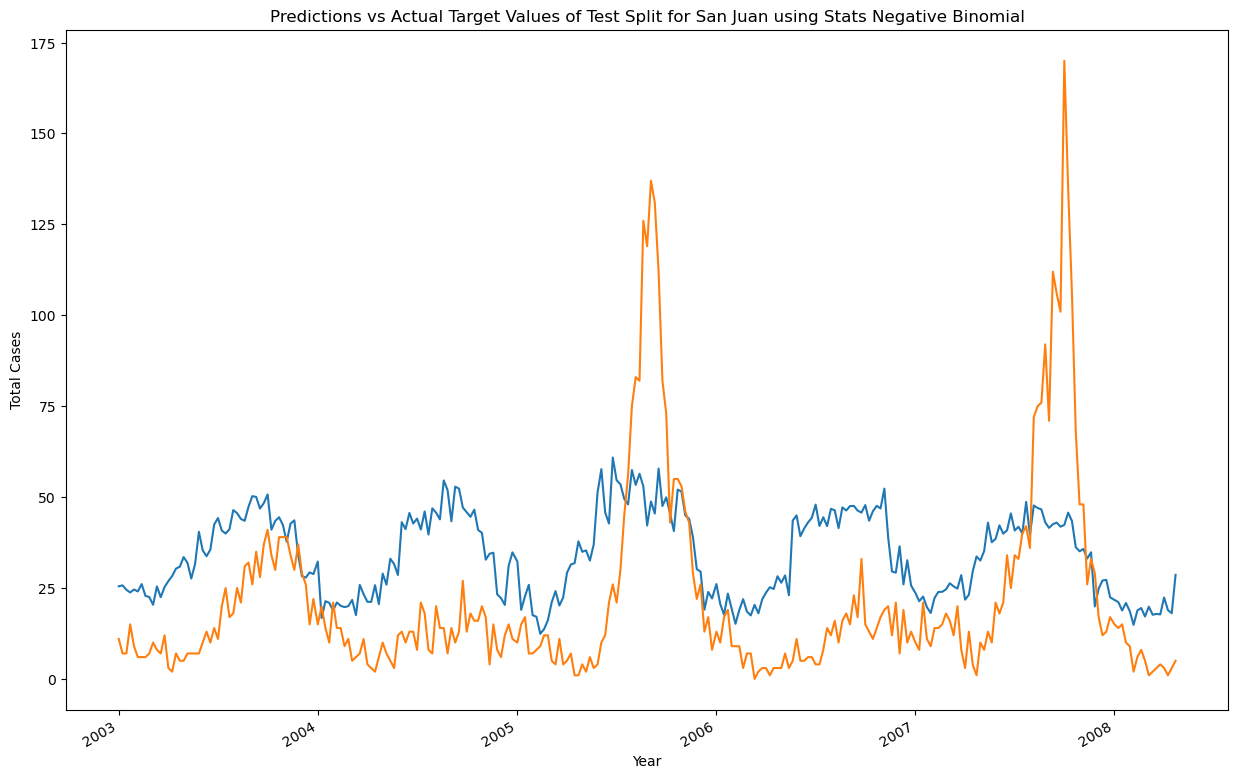

In [89]:
# Make Predictions and Visualize
VizPredictedvsActualStatsNegBin(dengue_sj_test, stats_model_sj, "Predictions vs Actual Target Values of Test Split for San Juan using Stats Negative Binomial")

In [90]:
# Evaluate the Predicitons
mse_sj_t2 = mean_squared_error(dengue_sj_test['fitted'].astype(int), dengue_sj_test['total_cases'])
print("MSE for the Stats Negative Binomial Time Series model for San Juan Dataset: ", mse_sj_t2)

MSE for the Stats Negative Binomial Time Series model for San Juan Dataset:  700.202166064982


In [91]:
# Prophet

# Get the prophet model for improvised train dataset
prophet_model_sj = GetProphet(y_sj_train)

23:57:05 - cmdstanpy - INFO - Chain [1] start processing
23:57:06 - cmdstanpy - INFO - Chain [1] done processing


In [92]:
# Get Test data ready for Prophet Model fitting
y_sj_test_rev = y_sj_test
y_sj_test_rev = y_sj_test_rev.reset_index()
y_sj_test_rev.rename(columns={'week_start_date': 'ds'}, inplace=True)

# Make predictions
y_sj_prophet_pred = prophet_model_sj.predict(y_sj_test_rev)

In [93]:
# Get Test data ready
y_sj_prophet_pred.index = y_sj_test.index
y_sj_prophet_pred['yhat'] = y_sj_prophet_pred['yhat'].astype(int)

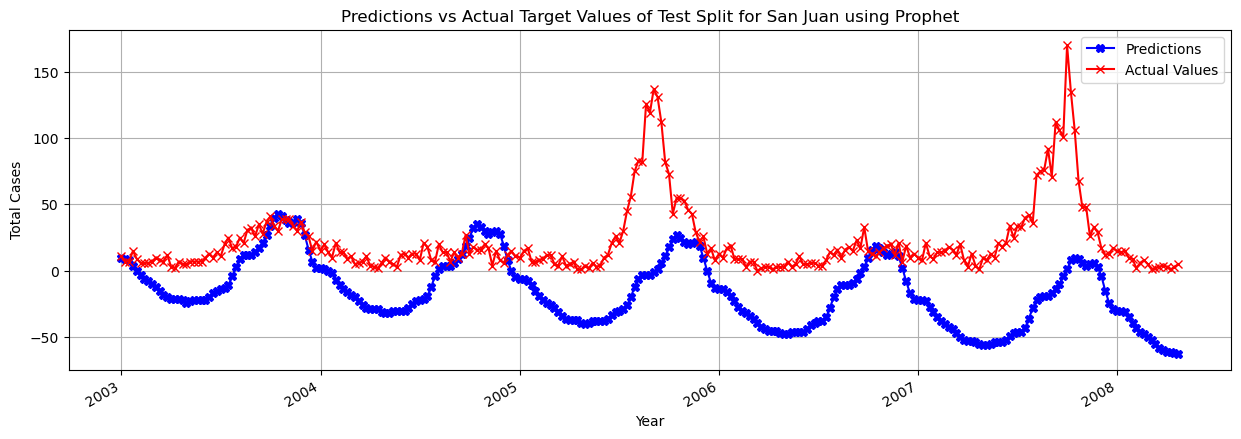

In [94]:
# Visualize Predictions
VizPredictedvsActualProphet(y_sj_prophet_pred, y_sj_test, "Predictions vs Actual Target Values of Test Split for San Juan using Prophet")

In [95]:
# Evaluate the Predictions
mse_sj_t3 = mean_squared_error(y_sj_prophet_pred['yhat'], dengue_sj_test['total_cases'])
print("MSE for the Stats Negative Binomial Time Series model for San Juan Dataset: ", mse_sj_t3)

MSE for the Stats Negative Binomial Time Series model for San Juan Dataset:  2251.8267148014443


+-------------------------+--------------------+
|          Model          |        MSE         |
+-------------------------+--------------------+
|          ARIMA          | 994.1083032490975  |
| Stats Negative Binomial |  700.202166064982  |
|         Prophet         | 2251.8267148014443 |
+-------------------------+--------------------+


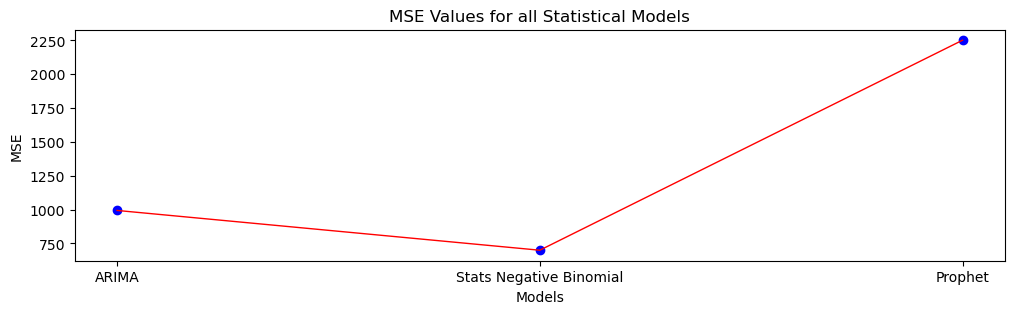

In [114]:
# Visualize the mse to find best model
best_model_sj2 = VizMSEValues2(mse_sj_t1, mse_sj_t2, mse_sj_t3, arima_model_sj, stats_model_sj, prophet_model_sj)

In [97]:
best_ts_model_sj = best_model_sj2[2][1]
best_ts_model_sj

### Iquitos

In [98]:
# ARIMA

# Find the best parameters for ARIMA 
best_param_iq = BestParamARIMA(y_iq_train)

Best ARIMA parameters: (1, 0, 2)
Best AIC: 2486.1742744247895


In [99]:
# Fit the ARIMA model with best parameters
arima_model_iq = ARIMA(y_iq_train, order=best_param_sj)
arima_model_iq_fit = arima_model_iq.fit()
print(arima_model_iq_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            total_cases   No. Observations:                  369
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -1246.299
Date:                Wed, 08 May 2024   AIC                           2502.598
Time:                        23:57:34   BIC                           2522.152
Sample:                             0   HQIC                          2510.366
                                - 369                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.4549      2.096      3.079      0.002       2.346      10.564
ar.L1         -0.1421      0.076     -1.858      0.063      -0.292       0.008
ar.L2          0.5546      0.068      8.131      0.0

In [100]:
# Making Predictions with best ARIMA Model with best parameters
# Validate the model
y_iq_pred = arima_model_iq_fit.forecast(steps=len(y_iq_test))
y_iq_pred.index = y_iq_test.index
y_iq_pred = pd.DataFrame(y_iq_pred)
y_iq_pred['predicted_mean'] = y_iq_pred['predicted_mean'].astype(int)

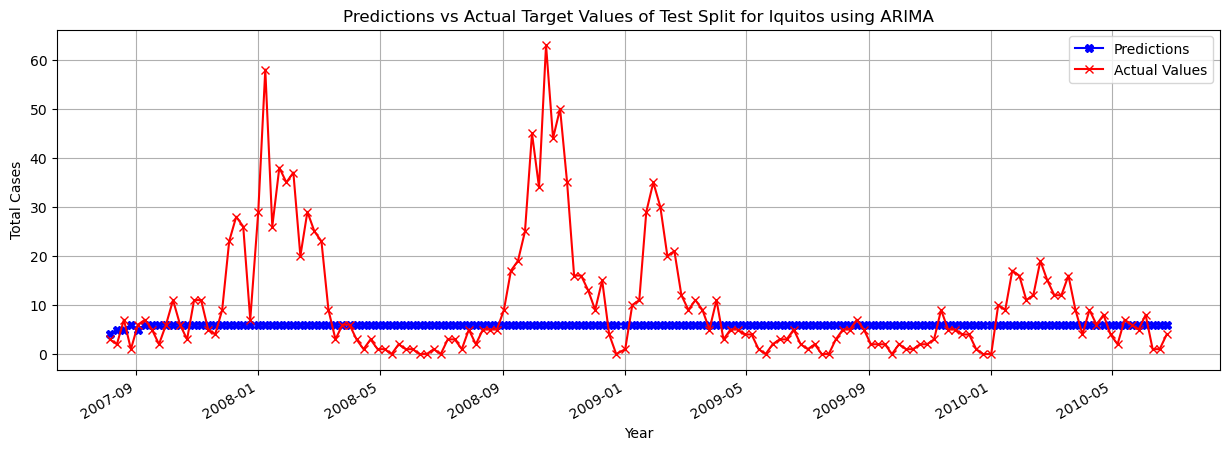

In [101]:
VizPredictedvsActualARIMA(y_iq_pred, y_iq_test, "Predictions vs Actual Target Values of Test Split for Iquitos using ARIMA")

In [102]:
# Evaluate the Best Model
mse_iq_t1 = mean_squared_error(y_iq_pred['predicted_mean'], y_iq_test['total_cases'])
print("MSE for the ARIMA TIme Series model for Iquitos Dataset: ", mse_iq_t1)

MSE for the ARIMA TIme Series model for Iquitos Dataset:  161.08609271523179


In [103]:
# Stats Negative Binomial

# Find Best Parameters for Stats Negative Binomial Model
# Specify the formule of the model for Stats Negative Binomial
model_formula_iq = "total_cases ~ 1 +" \
                    "reanalysis_specific_humidity_g_per_kg +" \
                    "reanalysis_dew_point_temp_k +" \
                    "reanalysis_min_air_temp_k"
stats_model_iq = GetStatsNegBinomialModel(dengue_iq_train, dengue_iq_test, model_formula_iq)

best alpha =  1e-08
best score =  7.317880794701987


In [104]:
# Find the best Stats Model summary
print(stats_model_iq.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            total_cases   No. Observations:                  520
Model:                            GLM   Df Residuals:                      516
Model Family:        NegativeBinomial   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3180.9
Date:                Wed, 08 May 2024   Deviance:                       4826.6
Time:                        23:57:42   Pearson chi2:                 6.96e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.6373
Covariance Type:            nonrobust                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

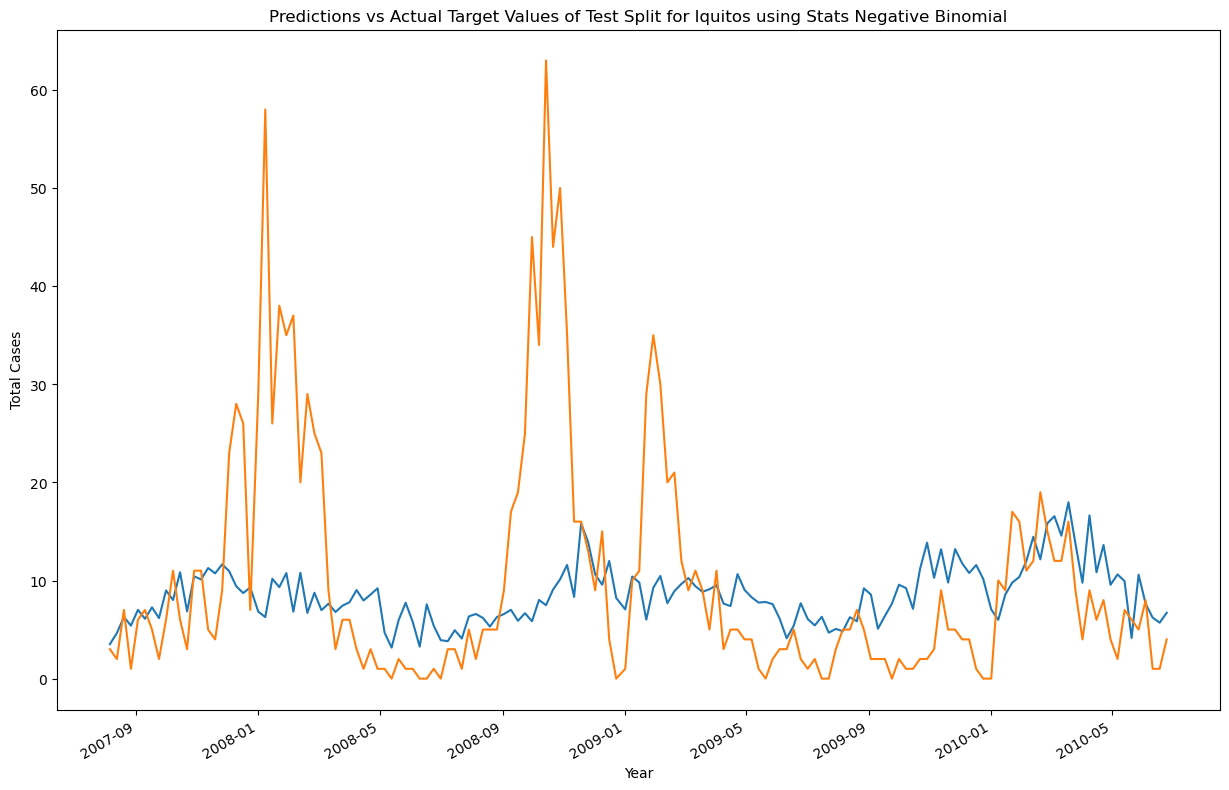

In [105]:
VizPredictedvsActualStatsNegBin(dengue_iq_test, stats_model_iq, "Predictions vs Actual Target Values of Test Split for Iquitos using Stats Negative Binomial")

In [106]:
# Evaluate the Best Model
mse_iq_t2 = mean_squared_error(dengue_iq_test['fitted'].astype(int), dengue_iq_test['total_cases'])
print("MSE for the Stats Negative Binomial Time Series model for San Juan Dataset: ", mse_iq_t2)

MSE for the Stats Negative Binomial Time Series model for San Juan Dataset:  145.7019867549669


In [107]:
# Prophet

# Get the prophet model for improvised train dataset
prophet_model_iq = GetProphet(y_iq_train)

23:57:52 - cmdstanpy - INFO - Chain [1] start processing
23:57:52 - cmdstanpy - INFO - Chain [1] done processing


In [108]:
# Get Test data ready for Prophet Model fitting
y_iq_test_rev = y_iq_test
y_iq_test_rev = y_iq_test_rev.reset_index()
y_iq_test_rev.rename(columns={'week_start_date': 'ds'}, inplace=True)

# Make predictions
y_iq_prophet_pred = prophet_model_iq.predict(y_iq_test_rev)

In [109]:
# Get Test data ready
y_iq_prophet_pred.index = y_iq_test.index
y_iq_prophet_pred['yhat'] = y_iq_prophet_pred['yhat'].astype(int)

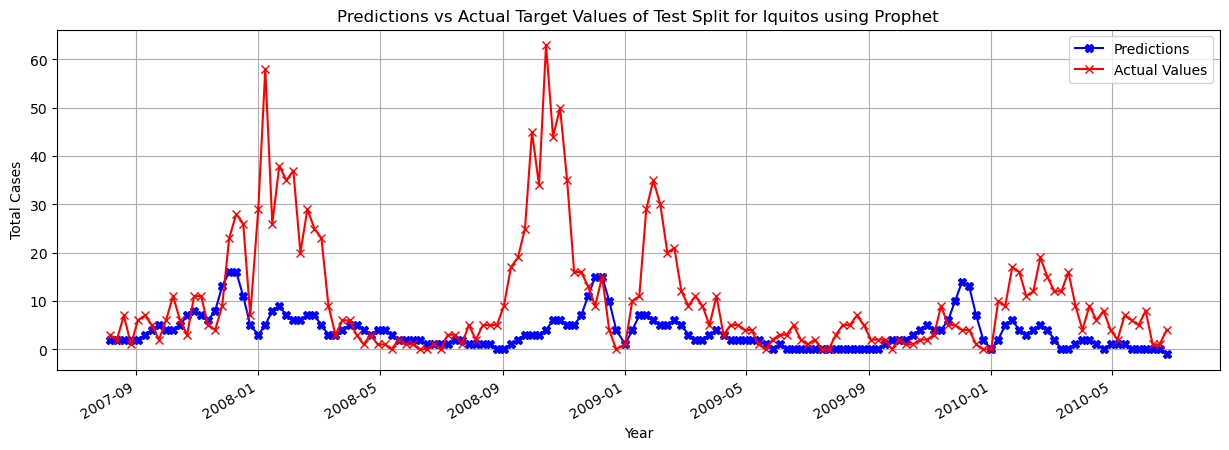

In [110]:
# Visualize Predictions
VizPredictedvsActualProphet(y_iq_prophet_pred, y_iq_test, "Predictions vs Actual Target Values of Test Split for Iquitos using Prophet")

In [111]:
# Evaluate the Predictions
mse_iq_t3 = mean_squared_error(y_iq_prophet_pred['yhat'], dengue_iq_test['total_cases'])
print("MSE for the Stats Negative Binomial Time Series model for San Juan Dataset: ", mse_iq_t3)

MSE for the Stats Negative Binomial Time Series model for San Juan Dataset:  167.75496688741723


+-------------------------+--------------------+
|          Model          |        MSE         |
+-------------------------+--------------------+
|          ARIMA          | 161.08609271523179 |
| Stats Negative Binomial | 145.7019867549669  |
|         Prophet         | 167.75496688741723 |
+-------------------------+--------------------+


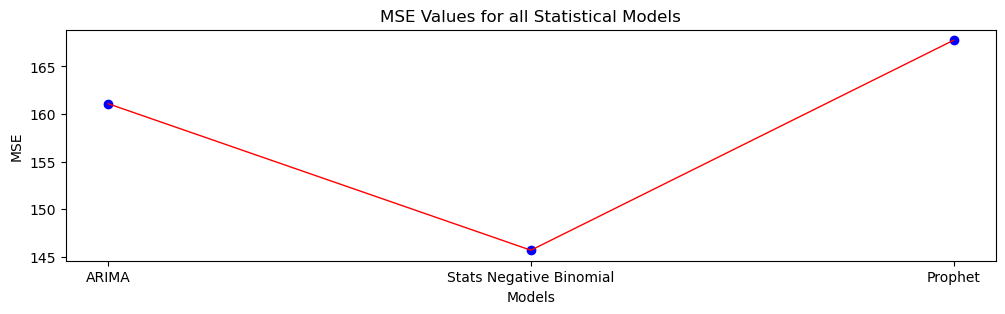

In [116]:
# Visualize the MSE to find the best model
best_model_iq2 = VizMSEValues2(mse_iq_t1, mse_iq_t2, mse_iq_t3, arima_model_iq, stats_model_iq, prophet_model_iq)

In [117]:
best_ts_model_iq = best_model_iq2[2][1]
best_ts_model_iq

# Final Testing Dataset

## Read Testing Dataset

**Worked on By: Vaishali Gupta**

In [118]:
# Preprocess the test data
# Read data from .csv test files
dengue_final_test = pd.read_csv("dengue_features_test.csv")

# Convert the date column to the DateTime data type
dengue_final_test["week_start_date"] = pd.to_datetime(dengue_final_test["week_start_date"])

# Set index to the year and weekofyear column
dengue_final_test = dengue_final_test.set_index('week_start_date', drop=True)
dengue_final_test.head()

city  year  weekofyear  ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
week_start_date                                                                 
2008-04-29        sj  2008          18  -0.0189 -0.018900  0.102729  0.091200   
2008-05-06        sj  2008          19  -0.0180 -0.012400  0.082043  0.072314   
2008-05-13        sj  2008          20  -0.0015       NaN  0.151083  0.091529   
2008-05-20        sj  2008          21      NaN -0.019867  0.124329  0.125686   
2008-05-27        sj  2008          22   0.0568  0.039833  0.062267  0.075914   

                 precipitation_amt_mm  reanalysis_air_temp_k  \
week_start_date                                                
2008-04-29                      78.60             298.492857   
2008-05-06                      12.56             298.475714   
2008-05-13                       3.66             299.455714   
2008-05-20                       0.00             299.690000   
2008-05-27                       0.76             299.780000   

                 reanalysis_avg_temp_k  ...  reanalysis_precip_amt_kg_per_m2  \
week_start_date                         ...                                    
2008-04-29                  298.550000  ...                            25.37   
2008-05-06                  298.557143  ...                            21.83   
2008-05-13                  299.357143  ...                             4.12   
2008-05-20                  299.728571  ...                             2.20   
2008-05-27                  299.671429  ...                             4.36   

                 reanalysis_relative_humidity_percent  \
week_start_date                                         
2008-04-29                                  78.781429   
2008-05-06                                  78.230000   
2008-05-13                                  78.270000   
2008-05-20                                  73.015714   
2008-05-27                                  74.084286   

                 reanalysis_sat_precip_amt_mm  \
week_start_date                                 
2008-04-29                              78.60   
2008-05-06                              12.56   
2008-05-13                               3.66   
2008-05-20                               0.00   
2008-05-27                               0.76   

                 reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  \
week_start_date                                                             
2008-04-29                                   15.918571           3.128571   
2008-05-06                                   15.791429           2.571429   
2008-05-13                                   16.674286           4.428571   
2008-05-20                                   15.775714           4.342857   
2008-05-27                                   16.137143           3.542857   

                 station_avg_temp_c  station_diur_temp_rng_c  \
week_start_date                                                
2008-04-29                26.528571                 7.057143   
2008-05-06                26.071429                 5.557143   
2008-05-13                27.928571                 7.785714   
2008-05-20                28.057143                 6.271429   
2008-05-27                27.614286                 7.085714   

                 station_max_temp_c  station_min_temp_c  station_precip_mm  
week_start_date                                                             
2008-04-29                     33.3                21.7               75.2  
2008-05-06                     30.0                22.2               34.3  
2008-05-13                     32.8                22.8                3.0  
2008-05-20                     33.3                24.4                0.3  
2008-05-27                     33.3                23.3               84.1  

[5 rows x 23 columns]

## Split Dataset for the two Cities

**Worked on By: Vaishali Gupta**

In [119]:
# Split data into separate cities because we don't want imputation from one city's data into another.
dengue_final_test_sj = dengue_final_test[dengue_final_test["city"] == "sj"]
dengue_final_test_iq = dengue_final_test[dengue_final_test["city"] == "iq"]
# Drop city column
dengue_final_test_sj = dengue_final_test_sj.drop("city", axis=1)
dengue_final_test_iq = dengue_final_test_iq.drop("city", axis=1)

In [120]:
dengue_final_test_sj.head()

year  weekofyear  ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
week_start_date                                                            
2008-04-29       2008          18  -0.0189 -0.018900  0.102729  0.091200   
2008-05-06       2008          19  -0.0180 -0.012400  0.082043  0.072314   
2008-05-13       2008          20  -0.0015       NaN  0.151083  0.091529   
2008-05-20       2008          21      NaN -0.019867  0.124329  0.125686   
2008-05-27       2008          22   0.0568  0.039833  0.062267  0.075914   

                 precipitation_amt_mm  reanalysis_air_temp_k  \
week_start_date                                                
2008-04-29                      78.60             298.492857   
2008-05-06                      12.56             298.475714   
2008-05-13                       3.66             299.455714   
2008-05-20                       0.00             299.690000   
2008-05-27                       0.76             299.780000   

                 reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  ...  \
week_start_date                                                      ...   
2008-04-29                  298.550000                   294.527143  ...   
2008-05-06                  298.557143                   294.395714  ...   
2008-05-13                  299.357143                   295.308571  ...   
2008-05-20                  299.728571                   294.402857  ...   
2008-05-27                  299.671429                   294.760000  ...   

                 reanalysis_precip_amt_kg_per_m2  \
week_start_date                                    
2008-04-29                                 25.37   
2008-05-06                                 21.83   
2008-05-13                                  4.12   
2008-05-20                                  2.20   
2008-05-27                                  4.36   

                 reanalysis_relative_humidity_percent  \
week_start_date                                         
2008-04-29                                  78.781429   
2008-05-06                                  78.230000   
2008-05-13                                  78.270000   
2008-05-20                                  73.015714   
2008-05-27                                  74.084286   

                 reanalysis_sat_precip_amt_mm  \
week_start_date                                 
2008-04-29                              78.60   
2008-05-06                              12.56   
2008-05-13                               3.66   
2008-05-20                               0.00   
2008-05-27                               0.76   

                 reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  \
week_start_date                                                             
2008-04-29                                   15.918571           3.128571   
2008-05-06                                   15.791429           2.571429   
2008-05-13                                   16.674286           4.428571   
2008-05-20                                   15.775714           4.342857   
2008-05-27                                   16.137143           3.542857   

                 station_avg_temp_c  station_diur_temp_rng_c  \
week_start_date                                                
2008-04-29                26.528571                 7.057143   
2008-05-06                26.071429                 5.557143   
2008-05-13                27.928571                 7.785714   
2008-05-20                28.057143                 6.271429   
2008-05-27                27.614286                 7.085714   

                 station_max_temp_c  station_min_temp_c  station_precip_mm  
week_start_date                                                             
2008-04-29                     33.3                21.7               75.2  
2008-05-06                     30.0                22.2               34.3  
2008-05-13                     32.8                22.8                3.0  
2008-05-20         

In [121]:
dengue_final_test_iq.head()

year  weekofyear   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
week_start_date                                                             
2010-07-02       2010          26  0.183783  0.142500  0.225129  0.150214   
2010-07-09       2010          27  0.291657  0.272267  0.330700  0.320914   
2010-07-16       2010          28  0.208543  0.366457  0.212629  0.255514   
2010-07-23       2010          29  0.089286  0.063214  0.122057  0.081957   
2010-07-30       2010          30  0.306100  0.327683  0.250086  0.267914   

                 precipitation_amt_mm  reanalysis_air_temp_k  \
week_start_date                                                
2010-07-02                      82.29             297.648571   
2010-07-09                      25.30             298.224286   
2010-07-16                      62.14             297.955714   
2010-07-23                      47.80             295.715714   
2010-07-30                      56.30             298.502857   

                 reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  ...  \
week_start_date                                                      ...   
2010-07-02                  299.214286                   296.118571  ...   
2010-07-09                  299.464286                   294.831429  ...   
2010-07-16                  298.964286                   296.417143  ...   
2010-07-23                  296.642857                   293.638571  ...   
2010-07-30                  300.000000                   293.892857  ...   

                 reanalysis_precip_amt_kg_per_m2  \
week_start_date                                    
2010-07-02                                 34.11   
2010-07-09                                  9.10   
2010-07-16                                 61.09   
2010-07-23                                 19.60   
2010-07-30                                 18.93   

                 reanalysis_relative_humidity_percent  \
week_start_date                                         
2010-07-02                                  92.581429   
2010-07-09                                  83.885714   
2010-07-16                                  92.057143   
2010-07-23                                  88.970000   
2010-07-30                                  78.610000   

                 reanalysis_sat_precip_amt_mm  \
week_start_date                                 
2010-07-02                              82.29   
2010-07-09                              25.30   
2010-07-16                              62.14   
2010-07-23                              47.80   
2010-07-30                              56.30   

                 reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  \
week_start_date                                                             
2010-07-02                                   17.654286           9.428571   
2010-07-09                                   16.320000          10.157143   
2010-07-16                                   18.030000           9.557143   
2010-07-23                                   15.394286           7.828571   
2010-07-30                                   15.468571          11.771429   

                 station_avg_temp_c  station_diur_temp_rng_c  \
week_start_date                                                
2010-07-02                   27.440                   10.760   
2010-07-09                   27.025                    9.625   
2010-07-16                   26.950                   10.350   
2010-07-23                   26.900                    9.700   
2010-07-30                   27.050                   11.850   

                 station_max_temp_c  station_min_temp_c  station_precip_mm  
week_start_date                                                             
2010-07-02                     33.8                21.5               11.2  
2010-07-09                     33.0                21.2                8.9  
2010-07-16                     33.4                21.6               22.6  
2010-07-23  

## Handle Missing Values in the two Cities Datasets

**Worked on By: Samiksha Sharma**

In [122]:
# Cleaning
# Find columns with any null values to be passed to function that counts the number of null values and prints it in a table
col_with_null_sj = dengue_final_test_sj.columns[dengue_final_test_sj.isnull().any()]
col_with_null_iq = dengue_final_test_iq.columns[dengue_final_test_iq.isnull().any()]

# Call function to again create and print table with count of Null values in all columns and check all are zero
NullColumnsTable_sj = CountMissingValues(dengue_final_test_sj, col_with_null_sj, "Count of Null/Missing Values for San Juan")
print(NullColumnsTable_sj)
NullColumnsTable_iq = CountMissingValues(dengue_final_test_iq, col_with_null_iq, "Count of Null/Missing Values for Iquitos")
print(NullColumnsTable_iq)

+---------------------------------------+-------------------------------------------+
|                 Column                | Count of Null/Missing Values for San Juan |
+---------------------------------------+-------------------------------------------+
|                ndvi_ne                |                     43                    |
|                ndvi_nw                |                     11                    |
|                ndvi_se                |                     1                     |
|                ndvi_sw                |                     1                     |
|          precipitation_amt_mm         |                     2                     |
|         reanalysis_air_temp_k         |                     2                     |
|         reanalysis_avg_temp_k         |                     2                     |
|      reanalysis_dew_point_temp_k      |                     2                     |
|       reanalysis_max_air_temp_k       |             

In [123]:
# Call function to replace/fill all missing values with median values
dengue_final_test_sj = ReplaceMissingValues(dengue_final_test_sj, col_with_null_sj, "mean")
dengue_final_test_iq = ReplaceMissingValues(dengue_final_test_iq, col_with_null_iq, "mean")

In [124]:
# Call function to again create and print table with count of Null values in all columns and check all are zero
NullColumnsTable_sj = CountMissingValues(dengue_final_test_sj, col_with_null_sj, "Count of Null/Missing Values for San Juan")
print(NullColumnsTable_sj)
NullColumnsTable_iq = CountMissingValues(dengue_final_test_iq, col_with_null_iq, "Count of Null/Missing Values for Iquitos")
print(NullColumnsTable_iq)

+---------------------------------------+-------------------------------------------+
|                 Column                | Count of Null/Missing Values for San Juan |
+---------------------------------------+-------------------------------------------+
|                ndvi_ne                |                     0                     |
|                ndvi_nw                |                     0                     |
|                ndvi_se                |                     0                     |
|                ndvi_sw                |                     0                     |
|          precipitation_amt_mm         |                     0                     |
|         reanalysis_air_temp_k         |                     0                     |
|         reanalysis_avg_temp_k         |                     0                     |
|      reanalysis_dew_point_temp_k      |                     0                     |
|       reanalysis_max_air_temp_k       |             

## Handle Scales of Columns in the two cities Datasets

**Worked on By: Shweta Bhati**

In [125]:
# Scaling
# Call the function to scale selected columns for each city dataset
dengue_final_test_sj = ScaleColumns(dengue_final_test_sj, weather_features)
dengue_final_test_iq = ScaleColumns(dengue_final_test_iq, weather_features)

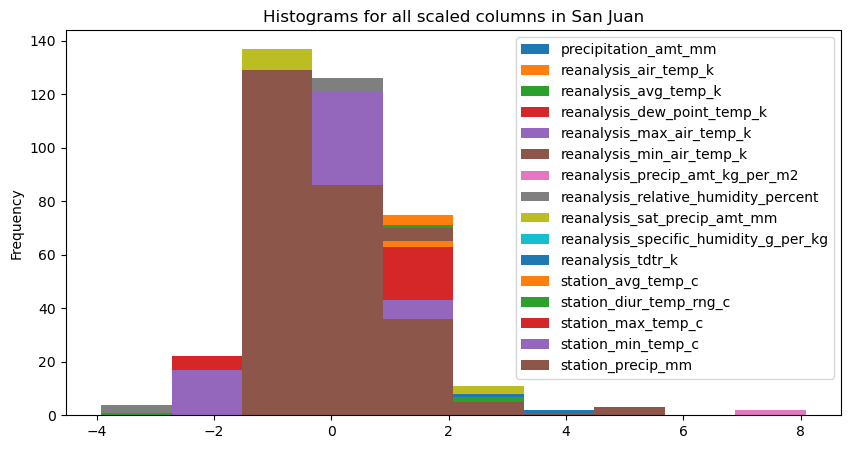

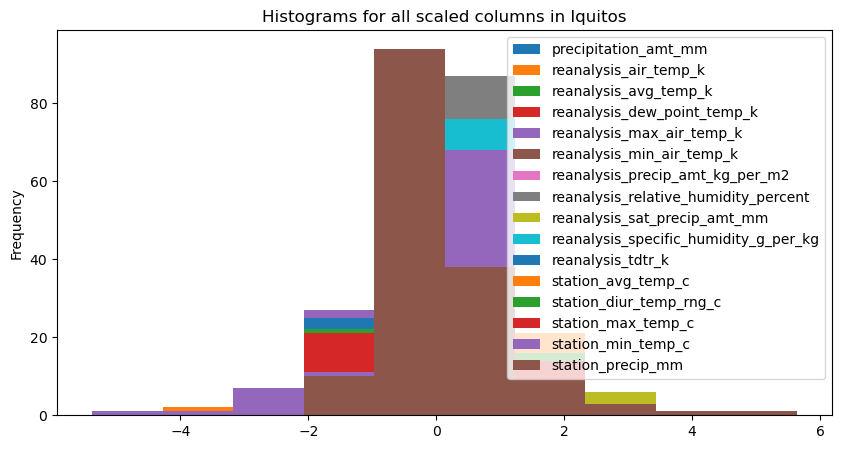

In [126]:
# Call function to plot histograms for scaled columns in each city
VizScaledCols(dengue_final_test_sj, weather_features, "Histograms for all scaled columns in San Juan")
VizScaledCols(dengue_final_test_iq, weather_features, "Histograms for all scaled columns in Iquitos")

## Feature Extraction

**Worked on By: Samiksha Sharma**

In [127]:
dengue_final_test_sj['ndvi_north'] = dengue_final_test_sj[['ndvi_ne', 'ndvi_nw']].mean(axis=1)
dengue_final_test_sj['ndvi_south'] = dengue_final_test_sj[['ndvi_se', 'ndvi_sw']].mean(axis=1)
dengue_final_test_iq['ndvi_mean'] = dengue_final_test_iq[['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw']].mean(axis=1)

dengue_final_test_sj['reanalysis_mean_temp_k'] = dengue_final_test_sj[['reanalysis_air_temp_k','reanalysis_avg_temp_k', 
                                     'reanalysis_dew_point_temp_k','reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k']].mean(axis=1)
dengue_final_test_iq['reanalysis_mean_temp_k'] = dengue_final_test_iq[['reanalysis_air_temp_k','reanalysis_avg_temp_k']].mean(axis=1)

In [128]:
dengue_final_test_sj = dengue_final_test_sj.drop("ndvi_ne", axis=1)
dengue_final_test_sj = dengue_final_test_sj.drop("ndvi_nw", axis=1)
dengue_final_test_sj = dengue_final_test_sj.drop("ndvi_se", axis=1)
dengue_final_test_sj = dengue_final_test_sj.drop("ndvi_sw", axis=1)

dengue_final_test_iq = dengue_final_test_iq.drop("ndvi_ne", axis=1)
dengue_final_test_iq = dengue_final_test_iq.drop("ndvi_nw", axis=1)
dengue_final_test_iq = dengue_final_test_iq.drop("ndvi_se", axis=1)
dengue_final_test_iq = dengue_final_test_iq.drop("ndvi_sw", axis=1)

dengue_final_test_sj = dengue_final_test_sj.drop("reanalysis_air_temp_k", axis=1)
dengue_final_test_sj = dengue_final_test_sj.drop("reanalysis_avg_temp_k", axis=1)
dengue_final_test_sj = dengue_final_test_sj.drop("reanalysis_dew_point_temp_k", axis=1)
dengue_final_test_sj = dengue_final_test_sj.drop("reanalysis_max_air_temp_k", axis=1)
dengue_final_test_sj = dengue_final_test_sj.drop("reanalysis_min_air_temp_k", axis=1)

dengue_final_test_iq = dengue_final_test_iq.drop("reanalysis_air_temp_k", axis=1)
dengue_final_test_iq = dengue_final_test_iq.drop("reanalysis_avg_temp_k", axis=1)

In [129]:
dengue_final_test_sj.head()

year  weekofyear  precipitation_amt_mm  \
week_start_date                                           
2008-04-29       2008          18              1.655533   
2008-05-06       2008          19             -0.443810   
2008-05-13       2008          20             -0.726731   
2008-05-20       2008          21             -0.843079   
2008-05-27       2008          22             -0.818919   

                 reanalysis_precip_amt_kg_per_m2  \
week_start_date                                    
2008-04-29                              0.046691   
2008-05-06                             -0.056373   
2008-05-13                             -0.571988   
2008-05-20                             -0.627887   
2008-05-27                             -0.565001   

                 reanalysis_relative_humidity_percent  \
week_start_date                                         
2008-04-29                                   0.170930   
2008-05-06                                   0.007969   
2008-05-13                                   0.019790   
2008-05-20                                  -1.532984   
2008-05-27                                  -1.217194   

                 reanalysis_sat_precip_amt_mm  \
week_start_date                                 
2008-04-29                           1.655533   
2008-05-06                          -0.443810   
2008-05-13                          -0.726731   
2008-05-20                          -0.843079   
2008-05-27                          -0.818919   

                 reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  \
week_start_date                                                             
2008-04-29                                   -0.499728           1.129902   
2008-05-06                                   -0.575837          -0.032580   
2008-05-13                                   -0.047349           3.842359   
2008-05-20                                   -0.585244           3.663515   
2008-05-27                                   -0.368889           1.994311   

                 station_avg_temp_c  station_diur_temp_rng_c  \
week_start_date                                                
2008-04-29                -0.527008                 1.321453   
2008-05-06                -0.850838                -0.869511   
2008-05-13                 0.464721                 2.385636   
2008-05-20                 0.555798                 0.173805   
2008-05-27                 0.242088                 1.363186   

                 station_max_temp_c  station_min_temp_c  station_precip_mm  \
week_start_date                                                              
2008-04-29                 0.956045           -0.945269           1.137802   
2008-05-06                -0.988012           -0.609439           0.002421   
2008-05-13                 0.661491           -0.206444          -0.866465   
2008-05-20                 0.956045            0.868210          -0.941416   
2008-05-27                 0.956045            0.129385           1.384865   

                 ndvi_north  ndvi_south  reanalysis_mean_temp_k  
week_start_date                                                  
2008-04-29        -0.018900    0.096964               -0.654372  
2008-05-06        -0.015200    0.077179               -0.673409  
2008-05-13         0.017615    0.121306               -0.112430  
2008-05-20         0.002467    0.125007                0.070127  
2008-05-27         0.048317    0.069090                0.070310

In [130]:
dengue_final_test_iq.head()

year  weekofyear  precipitation_amt_mm  \
week_start_date                                           
2010-07-02       2010          26              0.766284   
2010-07-09       2010          27             -1.026034   
2010-07-16       2010          28              0.132573   
2010-07-23       2010          29             -0.318416   
2010-07-30       2010          30             -0.051094   

                 reanalysis_dew_point_temp_k  reanalysis_max_air_temp_k  \
week_start_date                                                           
2010-07-02                          0.434086                   0.431127   
2010-07-09                         -0.603133                   0.337845   
2010-07-16                          0.674684                  -0.268482   
2010-07-23                         -1.564374                  -0.268482   
2010-07-30                         -1.359463                   0.524408   

                 reanalysis_min_air_temp_k  reanalysis_precip_amt_kg_per_m2  \
week_start_date                                                               
2010-07-02                        0.628109                        -0.717396   
2010-07-09                       -0.331274                        -1.183425   
2010-07-16                       -0.139397                        -0.214659   
2010-07-23                       -2.186080                        -0.987771   
2010-07-30                       -1.418574                        -1.000256   

                 reanalysis_relative_humidity_percent  \
week_start_date                                         
2010-07-02                                   0.448525   
2010-07-09                                  -0.862301   
2010-07-16                                   0.369493   
2010-07-23                                  -0.095876   
2010-07-30                                  -1.657583   

                 reanalysis_sat_precip_amt_mm  \
week_start_date                                 
2010-07-02                           0.766284   
2010-07-09                          -1.026034   
2010-07-16                           0.132573   
2010-07-23                          -0.318416   
2010-07-30                          -0.051094   

                 reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  \
week_start_date                                                             
2010-07-02                                    0.343346           0.050116   
2010-07-09                                   -0.698035           0.390320   
2010-07-16                                    0.636583           0.110152   
2010-07-23                                   -1.420536          -0.697000   
2010-07-30                                   -1.362557           1.144106   

                 station_avg_temp_c  station_diur_temp_rng_c  \
week_start_date                                                
2010-07-02                -0.135032                 0.012420   
2010-07-09                -0.689387                -0.764735   
2010-07-16                -0.789571                -0.268314   
2010-07-23                -0.856361                -0.713381   
2010-07-30                -0.655992                 0.758763   

                 station_max_temp_c  station_min_temp_c  station_precip_mm  \
week_start_date                                                              
2010-07-02                -0.124287            0.320556          -0.735613   
2010-07-09                -0.738292            0.086424          -0.808573   
2010-07-16                -0.431290            0.398599          -0.373985   
2010-07-23                -0.508040           -5.376639          -0.938632   
2010-07-30                -0.354539           -3.269457          -0.995731   

                 ndvi_mean  reanalysis_mean_temp_k  
week_start_date                                     
2010-07-02        0.175407                0.016380  
2010-07-09        0.303885                0.373566  
2010-07-16        0.260786     

# Regression Predictions on Final Datatset

**Worked on By: Samiksha Sharma**

In [131]:
# Make predictions
dengue_final_test_sj_preds = pd.Series(regression_model.predict(dengue_final_test_sj))
dengue_final_test_iq_preds = pd.Series(regression_model_2.predict(dengue_final_test_iq))

In [132]:
dengue_final_test_sj_preds = dengue_final_test_sj_preds.astype(int)
dengue_final_test_sj_preds.index = dengue_final_test_sj.index
dengue_final_test_iq_preds = dengue_final_test_iq_preds.astype(int)
dengue_final_test_iq_preds.index = dengue_final_test_iq.index

In [133]:
def VizFinalPred(pred, title):
    plt.figure(figsize=(10, 5))
    pred.plot(color='green', marker='o')
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel('Total Cases')
    plt.grid(True)
    plt.show()

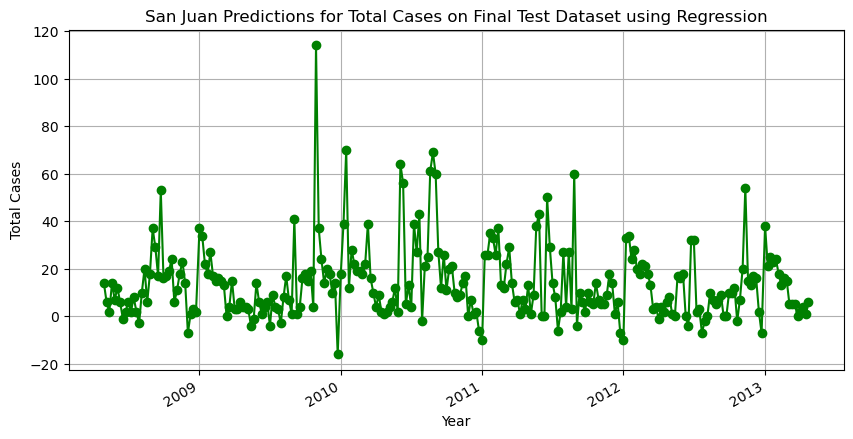

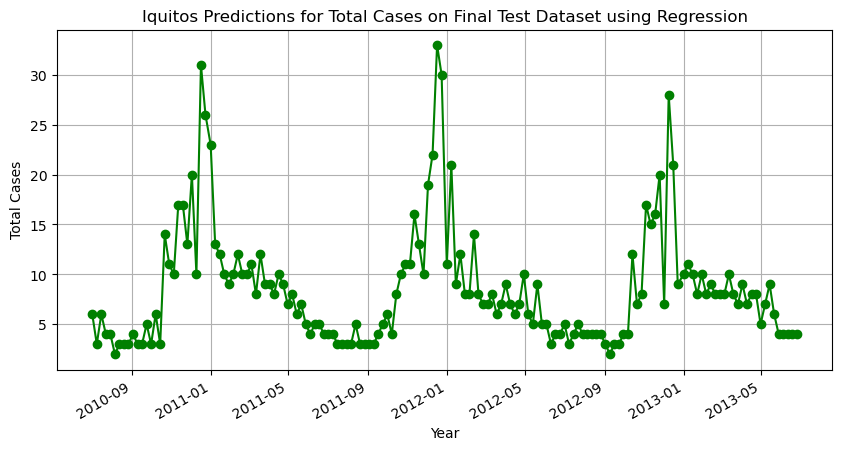

In [134]:
VizFinalPred(dengue_final_test_sj_preds, "San Juan Predictions for Total Cases on Final Test Dataset using Regression")
VizFinalPred(dengue_final_test_iq_preds, "Iquitos Predictions for Total Cases on Final Test Dataset using Regression")

In [135]:
# add column name to predictions
dengue_test_sj_preds_final = dengue_final_test_sj_preds.to_frame(name='total_cases')
dengue_test_iq_preds_final = dengue_final_test_iq_preds.to_frame(name='total_cases')
dengue_test_sj_preds_final['city'] = 'sj'
dengue_test_iq_preds_final['city'] = 'iq'
dengue_test_sj_preds_final = pd.merge(dengue_final_test_sj[dengue_final_test_sj.columns[0:2]], dengue_test_sj_preds_final, left_index=True, right_index=True)
dengue_test_iq_preds_final = pd.merge(dengue_final_test_iq[dengue_final_test_sj.columns[0:2]], dengue_test_iq_preds_final, left_index=True, right_index=True)
dengue_test_sj_preds_final = dengue_test_sj_preds_final[['city', 'year', 'weekofyear', 'total_cases']]
dengue_test_iq_preds_final = dengue_test_iq_preds_final[['city', 'year', 'weekofyear', 'total_cases']]

In [136]:
dengue_test_preds_final = pd.concat([dengue_test_sj_preds_final, dengue_test_iq_preds_final])

In [137]:
dengue_test_preds_final.to_csv('Test_Data_Regression_Preditions.csv', index=False)

# Time Series Predictions on Final Dataset

**Worked on By: Shweta Bhati**

In [138]:
# Make predictions
dengue_test_sj_stats_preds = pd.Series(best_ts_model_sj.predict(dengue_final_test_sj).astype(int))
dengue_test_iq_stats_preds = pd.Series(best_ts_model_iq.predict(dengue_final_test_iq).astype(int))

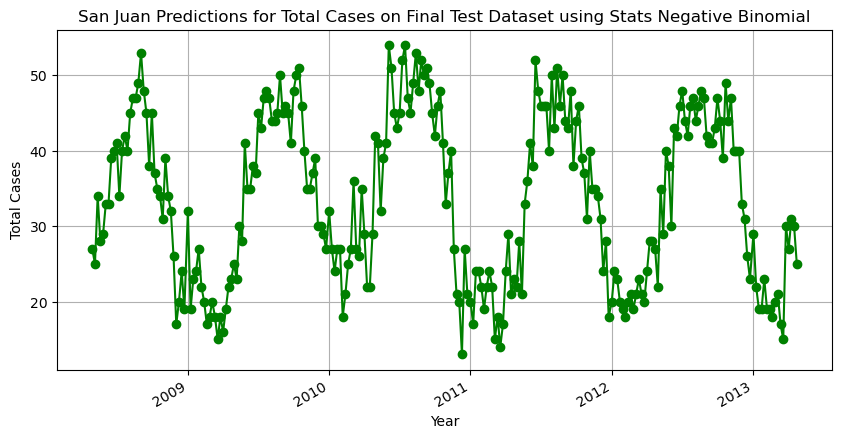

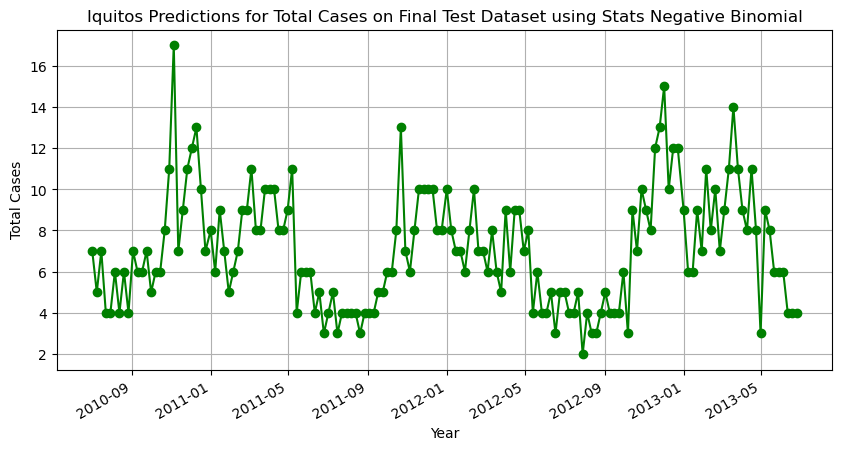

In [139]:
VizFinalPred(dengue_test_sj_stats_preds, "San Juan Predictions for Total Cases on Final Test Dataset using Stats Negative Binomial")
VizFinalPred(dengue_test_iq_stats_preds, "Iquitos Predictions for Total Cases on Final Test Dataset using Stats Negative Binomial")

In [140]:
# add column name to predictions
dengue_test_sj_stats_preds_final = dengue_test_sj_stats_preds.to_frame(name='total_cases')
dengue_test_iq_stats_preds_final = dengue_test_iq_stats_preds.to_frame(name='total_cases')
dengue_test_sj_stats_preds_final['city'] = 'sj'
dengue_test_iq_stats_preds_final['city'] = 'iq'
dengue_test_sj_stats_preds_final = pd.merge(dengue_final_test_sj[dengue_final_test_sj.columns[0:2]], dengue_test_sj_stats_preds_final, left_index=True, right_index=True)
dengue_test_iq_stats_preds_final = pd.merge(dengue_final_test_iq[dengue_final_test_sj.columns[0:2]], dengue_test_iq_stats_preds_final, left_index=True, right_index=True)
dengue_test_sj_stats_preds_final = dengue_test_sj_preds_final[['city', 'year', 'weekofyear', 'total_cases']]
dengue_test_iq_stats_preds_final = dengue_test_iq_preds_final[['city', 'year', 'weekofyear', 'total_cases']]

In [141]:
dengue_test_stats_preds_final = pd.concat([dengue_test_sj_stats_preds_final, dengue_test_iq_stats_preds_final])

In [142]:
dengue_test_stats_preds_final.to_csv('Test_Data_Time_Series_Preditions.csv', index=False)

**Final Code** was revised by Samiksha Sharma and proof read and retested by Shweta Bhati and Vaishali Gupta